# Задание

1. Напишите запрос, который показывает динамику оборотов и кол-ва операций по банкам в разрезе месяца. Какие можно сделать выводы из полученного результата?
2. Напишите запрос, показывающий процентный рост операций в разрезе банка, от месяца к месяцу. Какой это был банк, какой тип операций и в каком месяце максимальный рост в % и в номинальных значениях оборота.
3. Проведите анализ клиентов с FRAUD_FLAG = 1 и попробуйте понять, какие характеристики объединяют их.
Напишите запрос, позволяющий найти аналогичных клиентов, но с FRAUD_FLAG = 0.
Посчитайте долю операций таких клиентов от общей доли соответствующего типа операций в разрезе месяца.
4. Проведите всесторонний анализ датасета, представив статистику в разных срезах с графиками (библиотеки python) и выводами.
5. Если есть опыт использования ML\DL, попробуйте обучить модель на одном месяце и найдите клиентов в других месяцах.

# Импортирование необходимых библиотек

In [1]:
import re

from ydata_profiling import ProfileReport
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных и анализ данных

In [2]:
file_path = 'test_atm_analysis.csv'
data = pd.read_csv(file_path)

In [3]:
data.head()

TIME  TRANSACTION_ID  AMOUNT  \
0  2023-05-01 10:46:13    524834800723     390   
1  2023-05-01 10:47:46    524834800746     310   
2  2023-05-01 10:51:55    524834800795     390   
3  2023-05-01 11:14:58    524840527908      80   
4  2023-05-01 11:37:48    524848052828     590   

                                           CLIENT_ID  BANK_ID  \
0  BA2FE876DF8CDBDC5EC8549F764C996838D6EF9A3C0F5C...        1   
1  BA2FE876DF8CDBDC5EC8549F764C996838D6EF9A3C0F5C...        1   
2  17C0EC56C8190EC14D48749C760414BA8CFC565CD5E4E8...        1   
3  00547AF159358A2956CD20E787F65D2B4EC82C70CF98F3...        1   
4  2D0B6EBD900C5695C6A4380D29C71B173145BA7A5A56B3...        1   

                         CITY                   OPERATION_TYPE  FRAUD_FLAG  
0  Петропавловск-Камчатский г  Пополнение через наши банкоматы           0  
1  Петропавловск-Камчатский г  Пополнение через наши банкоматы           0  
2  Петропавловск-Камчатский г  Пополнение через наши банкоматы           0  
3                   Елизово г  Пополнение через наши банкоматы           0  
4                   Елизово г  Пополнение через наши банкоматы           0

In [4]:
print("Общая информация o данных:")
data.info()

Общая информация o данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873843 entries, 0 to 873842
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   TIME            873843 non-null  object
 1   TRANSACTION_ID  873843 non-null  int64 
 2   AMOUNT          873843 non-null  int64 
 3   CLIENT_ID       873843 non-null  object
 4   BANK_ID         873843 non-null  int64 
 5   CITY            873642 non-null  object
 6   OPERATION_TYPE  873843 non-null  object
 7   FRAUD_FLAG      873843 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 53.3+ MB


In [5]:
data.isnull().sum()

TIME                0
TRANSACTION_ID      0
AMOUNT              0
CLIENT_ID           0
BANK_ID             0
CITY              201
OPERATION_TYPE      0
FRAUD_FLAG          0
dtype: int64

Как мы видим у нас есть пропущенные значения в колонке CITY, скорее всего в этот момент мог произойти сбой или просто не записалось местоположение, поэтому заменим пропущенные значения на местоположение "Unknown", но перед этим посмотрим в каких строках пустые значения

In [6]:
data[data.isna().any(axis=1)]

TIME  TRANSACTION_ID  AMOUNT  \
5052    2023-05-01 18:37:08    525483926118     220   
7350    2023-05-01 15:33:28    525515321938     130   
29475   2023-05-03 11:11:08    525928764918      90   
29779   2023-05-03 14:23:46    525931917536     200   
49064   2023-05-05 19:52:32    526281844732     310   
...                     ...             ...     ...   
856849  2023-07-29 12:38:37    546097874727     190   
857903  2023-07-29 12:36:09    546104149039     550   
858998  2023-07-29 12:16:42    546110560662     140   
867725  2023-07-30 09:18:45    546933925135     100   
873477  2023-07-31 18:27:40    547385654720      90   

                                                CLIENT_ID  BANK_ID CITY  \
5052    C2604C019FAABAEC32EDDEEDEEA7BB84D678CD6D5346C2...       34  NaN   
7350    B7FBD2F0C3339D1A40873BDCCE79337948C7CE12525330...       34  NaN   
29475   6DC22804E13BAC433D8A8998BD43D1207206FDD7B56C64...       34  NaN   
29779   12D2D08848AA46837FD1B58DDC5F370705C31F47F3659C...       34  NaN   
49064   A924A4281B6A5D2202935EA813A1391A13A4C5B688E93E...       34  NaN   
...                                                   ...      ...  ...   
856849  660B8AA20A757AED9CB58108202D22E95D05BF20C554CF...       34  NaN   
857903  660B8AA20A757AED9CB58108202D22E95D05BF20C554CF...       34  NaN   
858998  CF2FB113F56902D746236B00F9BB7BD5047EDE511A7AFF...       34  NaN   
867725  58386BE668E84C594D5B918D84A13CC07F17298E2645AF...       34  NaN   
873477  F3182EE03797D66D65416A3E72ED518DB99E922FE357A9...       34  NaN   

                      OPERATION_TYPE  FRAUD_FLAG  
5052    Снятие через чужие банкоматы           0  
7350    Снятие через чужие банкоматы           0  
29475   Снятие через чужие банкоматы           0  
29779   Снятие через чужие банкоматы           0  
49064   Снятие через чужие банкоматы           0  
...                              ...         ...  
856849  Снятие через чужие банкоматы           0  
857903  Снятие через чужие банкоматы           0  
858998  Снятие через чужие банкоматы           0  
867725  Снятие через чужие банкоматы           0  
873477  Снятие через чужие банкоматы           0  

[201 rows x 8 columns]

In [7]:
data[data.isna().any(axis=1)]['BANK_ID'].unique()

array([34,  1], dtype=int64)

Исходя из данных выше, мы видим, что все пропущенные значения приходят от банка №34, скорей всего это может быть сбой или не было получено местоположение. Теперь можем заменить пропущенные значения на "Unknown" 

In [8]:
data['CITY'] = data['CITY'].fillna("Unknown")

In [9]:
data[data['CITY'] == "Unknown"]

TIME  TRANSACTION_ID  AMOUNT  \
5052    2023-05-01 18:37:08    525483926118     220   
7350    2023-05-01 15:33:28    525515321938     130   
29475   2023-05-03 11:11:08    525928764918      90   
29779   2023-05-03 14:23:46    525931917536     200   
49064   2023-05-05 19:52:32    526281844732     310   
...                     ...             ...     ...   
856849  2023-07-29 12:38:37    546097874727     190   
857903  2023-07-29 12:36:09    546104149039     550   
858998  2023-07-29 12:16:42    546110560662     140   
867725  2023-07-30 09:18:45    546933925135     100   
873477  2023-07-31 18:27:40    547385654720      90   

                                                CLIENT_ID  BANK_ID     CITY  \
5052    C2604C019FAABAEC32EDDEEDEEA7BB84D678CD6D5346C2...       34  Unknown   
7350    B7FBD2F0C3339D1A40873BDCCE79337948C7CE12525330...       34  Unknown   
29475   6DC22804E13BAC433D8A8998BD43D1207206FDD7B56C64...       34  Unknown   
29779   12D2D08848AA46837FD1B58DDC5F370705C31F47F3659C...       34  Unknown   
49064   A924A4281B6A5D2202935EA813A1391A13A4C5B688E93E...       34  Unknown   
...                                                   ...      ...      ...   
856849  660B8AA20A757AED9CB58108202D22E95D05BF20C554CF...       34  Unknown   
857903  660B8AA20A757AED9CB58108202D22E95D05BF20C554CF...       34  Unknown   
858998  CF2FB113F56902D746236B00F9BB7BD5047EDE511A7AFF...       34  Unknown   
867725  58386BE668E84C594D5B918D84A13CC07F17298E2645AF...       34  Unknown   
873477  F3182EE03797D66D65416A3E72ED518DB99E922FE357A9...       34  Unknown   

                      OPERATION_TYPE  FRAUD_FLAG  
5052    Снятие через чужие банкоматы           0  
7350    Снятие через чужие банкоматы           0  
29475   Снятие через чужие банкоматы           0  
29779   Снятие через чужие банкоматы           0  
49064   Снятие через чужие банкоматы           0  
...                              ...         ...  
856849  Снятие через чужие банкоматы           0  
857903  Снятие через чужие банкоматы           0  
858998  Снятие через чужие банкоматы           0  
867725  Снятие через чужие банкоматы           0  
873477  Снятие через чужие банкоматы           0  

[201 rows x 8 columns]

In [10]:
print("Статистика по числовым столбцам:")
data.describe()

Статистика по числовым столбцам:


TRANSACTION_ID         AMOUNT        BANK_ID     FRAUD_FLAG
count    8.738430e+05  873843.000000  873843.000000  873843.000000
mean     5.359082e+11     651.013592       2.641415       0.000595
std      6.382375e+09    1315.737246       3.719175       0.024387
min      5.248348e+11       0.000000       1.000000       0.000000
25%      5.305598e+11     160.000000       1.000000       0.000000
50%      5.361022e+11     330.000000       1.000000       0.000000
75%      5.416679e+11     610.000000       3.000000       0.000000
max      5.477769e+11  156590.000000      47.000000       1.000000

Теперь посмотрим на уникальные значения в колонке "CITY"

In [11]:
city_list = list(data['CITY'].unique())
city_list

['Петропавловск-Камчатский г',
 'Елизово г',
 'Невельск г',
 'Углегорск г',
 'БЕРДСК Г',
 'Владивосток г',
 'Артем г',
 'Уссурийск г',
 'Арсеньев г',
 'Большой Камень г',
 'Хабаровск г',
 'Корсаков г',
 'Г. КОМСОМОЛЬСК-НА-АМУРЕ',
 'Партизанск г',
 'Находка г',
 'Славянка пгт',
 'Биробиджан г',
 'Спасск-Дальний г',
 'Владивосток г Трудовое п',
 'Санкт-Петербург г',
 'БЕРДСК',
 'Саянск г Строителей мкр.',
 'Комсомольск-на-Амуре г',
 'ЮЖНО-САХАЛИНСК Г',
 'Шимановск г',
 'Ивановка с',
 'Г.ХАБАРОВСК',
 'Новосибирск г',
 'Чернышевск пгт',
 'Чита г',
 'Г.СВОБОДНЫЙ',
 'Благовещенск г',
 'ИРКУТСК Г',
 'Г. АНГАРСК',
 'Ангарск г 75 кв-л',
 'Братск г Энергетик жилрайон',
 'Якутск г',
 'Г. ЧЕРЕМХОВО',
 'Тулун г',
 'Ванино пгт.',
 'Зима г',
 'Г.АРСЕНЬЕВ',
 'Омск г',
 'Юрга г',
 'Барнаул г',
 'Магадан г',
 'Белогорск г',
 'Усть-Кут г',
 'Ангарск г 18 мкр.',
 'Г. ВЛАДИВОСТОК',
 'Улан-Удэ г',
 'Куйбышев г',
 'Г.',
 'Тында г',
 'КРАСНОЯРСК Г',
 'Белый Яр с',
 'Г.ИРКУТСК',
 'НЕРЮНГРИ Г',
 'Ангарск г',
 '

Как можем увидить у нас есть повторяющаюся точки, но по разному записанные, например: 'БЕРДСК' и 'БЕРДСК Г'; 'Г. КОМСОМОЛЬСК-НА-АМУРЕ' и 'Комсомольск-на-Амуре г'. Следовательно надо привести к одному формату.

Также посмотрим на наличие аномальных значений, например, если у нас есть город длиной в один символ

In [12]:
filtered_values = data[data['CITY'].apply(len) <= 4]
filtered_values['CITY'].unique()

array(['Г.', 'TVER', 'EYSK', 'OREL', 'PERM', 'OMSK', 'AZOV', 'UFA',
       'UHTA', 'ASHA', 'ORSK', 'TULA', 'SEYM', 'OB', 'UREN', 'SPB',
       'KLIN', 'ZIMA', 'BUY', 'Perm', 'ANNA', 'LUGA', 'TARA', 'OSA',
       'URAY', 'ELAN', 'ZEYA', 'BUI', 'GAY', 'Saki', 'KUSA', 'REZH',
       'OHA', 'BEYA', 'BOR', 'ABAN', 'OKHA', 'ILEK', 'АРСК', 'LUKH',
       'INTA', 'INZA', 'Azov', 'GAIY', 'OB G', 'TYLA', 'DNO', 'KIRS',
       'UGRA', 'OLGA', 'SAKI', 'YAYA', 'ENEM', 'ARSK', 'GDOV', 'RUZA',
       'SIVA', 'UYAR', 'EJSK', 'CHIK', 'LGOV', 'UMET', 'Omsk', 'URAI',
       'OLA', 'KALA', 'YAR', 'Klin', 'ISSA', 'EKB', 'KAZ', 'KOLA', 'AGOY',
       'EMVA', 'SIM', 'GAI', 'TUIM', 'BADA', 'KHOR', 'ROZA'], dtype=object)

Как мы видим у нас есть город с названием "Г.", такого города не существует, возможно, при выгрузке данных произошла какая ошибка или при записи, поэтому заменим на "Unknown"

In [13]:
fix = {
    'Г.': 'Unknown'
}

data['CITY'] = data['CITY'].replace(fix)

In [14]:
data[data['CITY'] == "Unknown"]

TIME  TRANSACTION_ID  AMOUNT  \
103     2023-05-01 12:44:28    524949286978     160   
155     2023-05-01 10:16:59    524976271119     200   
223     2023-05-01 14:09:20    525047430880     870   
298     2023-05-01 15:01:58    525065159968    3830   
305     2023-05-01 11:04:09    525065165279      80   
...                     ...             ...     ...   
861843  2023-07-31 10:04:16    546430646166    2110   
862330  2023-07-31 12:22:33    546639651993     550   
862425  2023-07-31 15:56:04    546667278994     360   
867725  2023-07-30 09:18:45    546933925135     100   
873477  2023-07-31 18:27:40    547385654720      90   

                                                CLIENT_ID  BANK_ID     CITY  \
103     4CE5D50C40579055C7BE38F815F47BE14681583E5213B1...        1  Unknown   
155     F3FBA8F545E6AE931DB5232FCE656F4CFB46C76E20927D...        1  Unknown   
223     E61C1FE7EBD661608BC80163BCBE0A1455E992E93D0FED...        1  Unknown   
298     D492957C48DF9A69F98C0D0DD95E117C6C1232E71AC48D...        1  Unknown   
305     1AA6BA28A0C2C754E563B6C0DB6957E981630C1D826A72...        1  Unknown   
...                                                   ...      ...      ...   
861843  9DBBD0F5C5E5B9DFC1E45EA6742EE3485B0848A4C0F523...        1  Unknown   
862330  AF5D4D500E7CAED27573319EED31D708E273241FA48EB5...        1  Unknown   
862425  B1534764F54118263E0595ED28D282CB3F8A4666246C56...        1  Unknown   
867725  58386BE668E84C594D5B918D84A13CC07F17298E2645AF...       34  Unknown   
873477  F3182EE03797D66D65416A3E72ED518DB99E922FE357A9...       34  Unknown   

                         OPERATION_TYPE  FRAUD_FLAG  
103     Пополнение через наши банкоматы           0  
155     Пополнение через наши банкоматы           0  
223     Пополнение через наши банкоматы           0  
298     Пополнение через наши банкоматы           0  
305     Пополнение через наши банкоматы           0  
...                                 ...         ...  
861843  Пополнение через наши банкоматы           0  
862330  Пополнение через наши банкоматы           0  
862425  Пополнение через наши банкоматы           0  
867725     Снятие через чужие банкоматы           0  
873477     Снятие через чужие банкоматы           0  

[1712 rows x 8 columns]

Теперь можем попробуем привести повторяющиеся значения поля "CITY" к одному формату

In [15]:
len(data['CITY'].unique())

6415

In [16]:
value_counts = data['CITY'].value_counts()
less_data = value_counts[value_counts < 40]
less_data

CITY
KAMENSKIY        39
Тосно г          39
KOZELSK          39
Хвалынск г       39
TOTSKIY          39
                 ..
ISSINSKIY         1
RTISHEVO          1
NACHALOVO         1
PITERKA           1
PRIRECHENSKAY     1
Name: count, Length: 3834, dtype: int64

In [17]:
top10 = data['CITY'].value_counts().nlargest(250)
top10

CITY
MOSKVA           34945
MOSKVA G         13709
SANKT PETERBU    12974
Москва г         10410
NOVOSIBIRSK       7980
                 ...  
Брянск г           650
Город г            649
NORILSK            647
MYTISCHI           647
PETROPAVLOVSK      644
Name: count, Length: 250, dtype: int64

In [18]:
top10 = list(set(list(top10.index)))
latin_cities = [city for city in top10 if not re.search(r'[а-яА-Я]', city)]
print(latin_cities)

['KOSTROMA G', 'ANGARSK', 'OMSK', 'KRASNOIARSK G', 'PENZA', 'MOSKVA G', 'LYUBERTSY', 'CHEREPOVETS', 'VOLGOGRAD G', 'VOLGODONSK', 'NIZHNEVARTOVS', 'TAMBOV', 'NAHODKA', 'NOGINSK', 'ASTRAHAN', 'KURSK', 'BARNAUL G', 'NOVOKUZNETSK', 'NIZHNII NOVGO', 'IZHEVSK', 'SOCHI  TSENTRALN', 'BELORECHENSK', 'MAYKOP', 'NOVOCHERKASSK', 'PSKOV', 'SAMARA G', 'CHEBOKSARY G', 'IAROSLAVL G', 'YAROSLAVL', 'IRKUTSK', 'VOLOGDA G', 'SOCHI', 'EKATERINBURG', 'BLAGOVESCHENSK', 'VORONEZH G', 'ELEKTROSTAL', 'IRKUTSK G', 'SARANSK', 'KHABAROVSK', 'STAVROPOL', 'SURGUT', 'NOVOROSSIYSK', 'STERLITAMAK', 'ZHELEZNOGORSK', 'SANKT PETERBU', 'GORNO ALTAYSK', 'GELENDZHIK', 'PENZA G', 'NIZHNIY TAGIL', 'NABEREZHNYE C', 'VOLOGDA', 'PODOLSK', 'ULIANOVSK G', 'CHEREPOVETS G', 'ULYANOVSK', 'KALININGRAD G', 'RYAZAN', 'BLAGOVESHCHEN', 'OKTYABRSKIY', 'YOSHKAR OLA', 'BELGOROD', 'BATAYSK', 'SEVERODVINSK', 'SANKT PETERBURG', 'ELETS', 'CHITA', 'ARMAVIR', 'VLADIMIR', 'MOSCOW', 'KEMEROVO', 'VORONEZH', 'USSURIYSK', 'SMOLENSK', 'BRATSK', 'NALCHIK'

In [19]:
replacement_dict = {
    'MOSKVA': 'Москва',
    'SANKT PETERBU': 'Санкт-Петербург',
    'NOVOSIBIRSK': 'Новосибирск',
    'SARATOV': 'Саратов',
    'EKATERINBURG': 'Екатеринбург',
    'KRASNODAR': 'Краснодар',
    'MOSCOW': 'Москва',
    'BARNAUL': 'Барнаул',
    'SAMARA': 'Самара',
    'KAZAN': 'Казань',
    'SANKT PETERBURG': 'Санкт-Петербург',
    'CHELYABINSK': 'Челябинск',
    'VOLGOGRAD': 'Волгоград',
    'KRASNOYARSK': 'Красноярск',
    'PERM': 'Пермь',
    'TOMSK': 'Томск',
    'TVER': 'Тверь',
    'ROSTOV NA DON': 'Ростов-на-дону',
    'VORONEZH': 'Воронеж',
    'OMSK': 'Омск',
    'UFA': 'Уфа',
    'IRKUTSK': 'Иркутск',
    'NIZHNIY NOVGO': 'Нижний новгород',
    'KALININGRAD': 'Калининград',
    'SOCHI': 'Сочи',
    'ELEKTROSTAL': 'Электросталь',
    'MURMANSK': 'Мурманск',
    'KURSK': 'Курск',
    'PENZA': 'Пенза',
    'ORENBURG': 'Оренбург',
    'LIPETSK': 'Липецк',
    'VLADIVOSTOK': 'Владивосток',
    'TYUMEN': 'Тюмень',
    'KEMEROVO': 'Кемерово',
    'VLADIKAVKAZ': 'Владикавказ',
    'IZHEVSK': 'Ижевск',
    'NOVOKUZNETSK': 'Новокузнецк',
    'KOSTROMA': 'Кострома',
    'CHEBOKSARY': 'Чебоксары',
    'ROSTOV NA DONU': 'Ростов-на-дону',
    'IVANOVO': 'Иваново',
    'STAVROPOL': 'Ставраполь',
    'TULA': 'Тула',
    'ULYANOVSK': 'Ульяновск',
    'ENGELS': 'Энгельс',
    'KHABAROVSK': 'Хабаровск',
    'PETROZAVODSK': 'Петрозаводск',
    'SARANSK': 'Саранск',
    'NOVOROSSIYSK': 'Новороссийск',
    'MAGNITOGORSK': 'Магнитогорск',
    'ZELENOGRAD': 'Зеленоград',
    'PROKOPEVSK': 'Прокопьевск',
    'PUSHKINO': 'Пушкино',
    'BERDSK': 'Бердск',
    'NOGINSK': 'Ногинск',
    'BELGOROD': 'Белгород',
    'MYTISHCHI': 'Мытищи',
    'YAROSLAVL': 'Ярославль',
    'ABAKAN': 'Абакан',
    'KHIMKI': 'Химки',
    'ANAPA': 'Анапа',
    'KURGAN': 'Курган',
    'ORSK': 'Орск',
    'STERLITAMAK': 'Стерлитамак',
    'NABEREZHNYE CHEL': 'Набережные Челны',
    'BALASHIKHA': 'Балашиха',
    'ARTEM': 'Артем',
    'LYUBERTSY': 'Люберцы',
    'BALAKOVO': 'Балаково',
    'TAGANROG': 'Таганрог',
    'KYZYL': 'Кызыл',
    'NALCHIK': 'Нальчик',
    'RYAZAN': 'Рязань',
    'VOLOGDA': 'Вологда',
    'BIYSK': 'Бийск',
    'PSKOV': 'Псков',
    'DIMITROVGRAD': 'Димитровград',
    'KROPOTKIN': 'Кропоткин',
    'KRASNOGORSK': 'Красногорск',
    'CHEREPOVETS': 'Череповец',
    'OREL': 'Орёл',
    'PODOLSK': 'Подольск',
    'ELETS': 'Елец',
    'BRATSK': 'Братск',
    'VOLZHSKIY': 'Волжский',
    'DOMODEDOVO': 'Домодедово',
    'NIZHNEVARTOVS': 'Нижневартовск',
    'SYZRAN': 'Сызрань',
    'BELOVO': 'Белово',
    'NIZHNII NOVGO': 'Нижний Новгород',
    'NIZHNIY NOVGOROD': 'Нижний Новгород',
    'KHABAROVSK': 'Хабаровск',
    'ANGARSK': 'Ангарск',
    'BALASHIHA': 'Балашиха',
    'IAROSLAVL': 'Ярославль',
    'YAKUTSK': 'Якутск',
    'BRYANSK': 'Брянск',
    'ULAN UDE': 'Улан-Удэ',
    'KALUGA': 'Калуга',
    'PYATIGORSK': 'Пятигорск',
    'SURGUT': 'Сургут',
    'NOVOCHERKASSK': 'Новочеркасск',
    'ARKHANGELSK': 'Архангельск',
    'SHAKHTY': 'Шахты',
    'KRASNOIARSK': 'Красноярск',
    'SMOLENSK': 'Смоленск',
    'VLADIMIR': 'Владимир',
    'SYKTYVKAR': 'Сыктывкар',
    'TAMBOV': 'Тамбов',
    'VOLGODONSK': 'Волгодонск',
    'KISLOVODSK': 'Кисловодск',
    'CHITA': 'Чита',
    'BLAGOVESCHENSK': 'Благовещенск',
    'USSURIYSK': 'Уссурийск',
    'TIUMEN': 'Тюмень',
    'OBNINSK': 'Обнинск',
    'RAMENSKOE': 'Раменское',
    'KOROLEV': 'Королёв',
    'GELENDZHIK': 'Геленджик',
    'OKTYABRSKIY': 'Октябрьский',
    'ASTRAKHAN': 'Астрахань',
    'ARMAVIR': 'Армавир',
    'CHERKESSK': 'Черкесск',
    'VIDNOE': 'Видное',
    'KIROV': 'Киров',
    'ODINTSOVO': 'Одинцово',
    'MAYKOP': 'Майкоп',
    'ASTRAHAN': 'Астрахань',
    'TOLYATTI': 'Тольятти',
    'BLAGOVESHCHEN': 'Благовещенск',
    'RYBINSK': 'Рыбинск',
    'NIZHNEKAMSK': 'Нижнекамск',
    'ST PETERSBURG': 'Санкт-Петербург',
    'GORNO ALTAYSK': 'Горно-Алтайск',
    'DZERZHINSK': 'Дзержинск',
    'NEVINNOMYSSK': 'Невинномысск',
    'NORILSK': 'Норильск',
    'ALEKSIN': 'Алексин',
    'NIZHNIY TAGIL': 'Нижний Тагил',
    'YOSHKAR OLA': 'Йошкар-Ола',
    'KHABAROVSK': 'Хабаровск',
    'REUTOV': 'Реутов',
    'BEREZNIKI': 'Березники',
    'BRIANSK': 'Брянск',
    'BELORECHENSK': 'Белореченск',
    'ESSENTUKI': 'Ессентуки',
    'BATAYSK': 'Батайск',
    'SEVERODVINSK': 'Северодвинск',
    'TROITSK': 'Троицк',
    'MIASS': 'Миасс',
    'RUBTSOVSK': 'Рубцовск',
    'NEFTEKAMSK': 'Нефтекамск',
    'ULIANOVSK': 'Ульяновск',
    'TOLIATTI': 'Тольятти',
    'SOCHI TSENTRALN': 'Сочи Центральный',
    'KHABAROVSK': 'Хабаровск',
    'CHELIABINSK': 'Челябинск',
    'NABEREZHNYE C': 'Набережные Челны',
    'MAKHACHKALA': 'Махачкала',
    'ZHELEZNOGORSK': 'Железногорск',
    'SOCHI  TSENTRALN': 'Сочи Центральный',
    'KHABAROVSK': 'Хабаровск',
    'ACHINSK': 'Ачинск',
    'MAGADAN': 'Магадан',
    'MURINO': 'Мурино',
    'IOSHKAR OLA': 'Йошкар-Ола',
    'KOLPINO': 'Колпино',
    'KLIN': 'Клин',
    'KOMSOMOLSK NA AM': 'Комсомольск-на-Амуре',
    'PETROPAVLOVSK': 'Петропавловск',
    'TUAPSE': 'Туапсе',
    'GEORGIEVSK': 'Георгиевск',
    'KOMSOMOLSK NA': 'Комсомольск-на-Амуре',
    'SERGIEV POSAD': 'Сергиев Посад',
    'DZERZHINSKIY': 'Дзержинский',
    'KOTLAS': 'Котлас',
    'KOTELNIKI': 'Котельники',
    'KRYMSK': 'Крымск',
    'PIATIGORSK': 'Пятигорск',
    'LOBNYA': 'Лобня',
    'RZHEV': 'Ржев',
    'SEVERSK': 'Северск',
    'GLAZOV': 'Глазов',
    'ELISTA': 'Элиста',
    'ROSTOV ON DON': 'Ростов-на-Дону',
    'KUDROVO': 'Кудрово',
    'IVANTEEVKA': 'Ивантеевка',
    'DONETSK': 'Донецк',
    'ROSLAVL': 'Рославль',
    'MINUSINSK': 'Минусинск',
    'CHISTOPOL': 'Чистополь',
    'YUZHNO SAHALINSK': 'Южно-Сахалинск',
    'NOVOALTAYSK': 'Новоалтайск',
    'CHERNOGORSK': 'Черногорск',
    'PETROPAVLOVSK KA': 'Петропавловск-Камчатский',
    'KOVROV': 'Ковров',
    'RIAZAN': 'Рязань',
    'MARKS': 'Маркс',
    'ZHUKOVSKIY': 'Жуковский',
    'LABINSK': 'Лабинск',
    'NIZHNIY LOMOV': 'Нижний Ломов',
    'STUPINO': 'Ступино',
    'SALAVAT': 'Салават',
    'ALEKSANDROV': 'Александров',
    'EGOREVSK': 'Егорьевск',
    'PUSHKIN': 'Пушкин',
    'STARYI OSKOL': 'Старый Оскол',
    'PUGACHEV': 'Пугачёв',
    'BALASHOV': 'Балашов',
    'PERVOURALSK': 'Первоуральск',
    'KHABAROVSK': 'Хабаровск',
    'UST ILIMSK': 'Усть-Илимск',
    'NAKHODKA': 'Находка',
    'HIMKI': 'Химки',
    'KAMYSHIN': 'Камышин',
    'URYUPINSK': 'Урюпинск',
    'CHAPAEVSK': 'Чапаевск',
    'NARO FOMINSK': 'Наро-Фоминск',
    'SCHELKOVO': 'Щёлково',
    'MYTISCHI': 'Мытищи',
    'ISTRA': 'Истра',
    'SOCHI ADLERSKIY': 'Сочи Адлерский',
    'YURGA': 'Юрга',
    'AKSAY': 'Аксай',
    'ST PETERBURG': 'Санкт-Петербург',
    'KANSK': 'Канск',
    'BUZULUK': 'Бузулук',
    'AZOV': 'Азов',
    'NOVOMOSKOVSK': 'Новомосковск',
    'NOVOROSSIISK': 'Новороссийск',
    'ELIZOVO': 'Елизово',
    'ALMETEVSK': 'Альметьевск',
    'YUZHNO SAKHAL': 'Южно-Сахалинск',
    'OREKHOVO ZUEV': 'Орехово-Зуево',
    'LISKI': 'Лиски',
    'VELIKII NOVGO': 'Великий Новгород',
    'TULUN': 'Тулун',
    'DINSKAYA': 'Динская',
    'MICHURINSK': 'Мичуринск',
    'TOBOLSK': 'Тобольск',
    'BORISOGLEBSK': 'Борисоглебск',
    'DMITROV': 'Дмитров',
    'EYSK': 'Ейск',
    'SOLIKAMSK': 'Соликамск',
    'ZLATOUST': 'Златоуст',
    'KUZNETSK': 'Кузнецк',
    'USOLE SIBIRSKOE': 'Усолье-Сибирское'
}

In [20]:
def normalize_city_name(city):
    city = re.sub(r'\bг\.\s*', '', city, flags=re.IGNORECASE)
    city = re.sub(r'[^\w\s-]', '', city, flags=re.IGNORECASE)
    city = re.sub(r'\bг\b|\bg\b|\bG\b', '', city, flags=re.IGNORECASE).strip()

    city_upper = city.upper()

    return replacement_dict.get(city_upper, city_upper.capitalize())

In [21]:
data['CITY'] = data['CITY'].apply(normalize_city_name)

В ходе приведения к одному формату было обноружено, что у нас есть еще одна аномальная метка "Город", ее тоже заменим на "Unknown"

In [22]:
data[data['CITY'] == "Город"]

TIME  TRANSACTION_ID  AMOUNT  \
8752    2023-05-03 12:38:11    525538458781     390   
8924    2023-05-03 13:03:44    525542215934     190   
10631   2023-05-03 18:17:29    525579553259     200   
17638   2023-05-04 12:06:34    525727624464     630   
19917   2023-05-04 14:52:18    525751773378     280   
...                     ...             ...     ...   
861632  2023-07-31 10:31:57    546135336137     160   
861851  2023-07-31 12:05:34    546433833604     700   
862006  2023-07-31 15:42:23    546519205833     110   
862115  2023-07-31 14:13:47    546574825847      90   
862753  2023-07-31 17:40:43    546739849053      90   

                                                CLIENT_ID  BANK_ID   CITY  \
8752    8FA54374685D5DC095830B0957DB2FC75A0712ACF02DBE...        1  Город   
8924    14890314B43087A21A534E14BE400729DB3D9806A2EE04...        1  Город   
10631   8FA54374685D5DC095830B0957DB2FC75A0712ACF02DBE...        1  Город   
17638   02878D3F548376EACF47C79DFBFFBCC2EBD13611A22669...        1  Город   
19917   DF05508A31CCB21167DC18AEA7593BC55DBE216FF518BF...        1  Город   
...                                                   ...      ...    ...   
861632  FC686C2B20079A75247CAD2A1BD89FB265B924592D1190...        1  Город   
861851  02878D3F548376EACF47C79DFBFFBCC2EBD13611A22669...        1  Город   
862006  5058F2172F476B44D9C4517EE3CE6B35A9B423C194252F...        1  Город   
862115  F45D2833B3B79C273A2F6214F2DAF03532A2E5A77A51C1...        1  Город   
862753  AECB14EAFB440C2633163854A4121088CAFA261C68E24B...        1  Город   

                         OPERATION_TYPE  FRAUD_FLAG  
8752    Пополнение через наши банкоматы           0  
8924    Пополнение через наши банкоматы           0  
10631   Пополнение через наши банкоматы           0  
17638   Пополнение через наши банкоматы           0  
19917   Пополнение через наши банкоматы           0  
...                                 ...         ...  
861632  Пополнение через наши банкоматы           0  
861851  Пополнение через наши банкоматы           0  
862006  Пополнение через наши банкоматы           0  
862115  Пополнение через наши банкоматы           0  
862753  Пополнение через наши банкоматы           0  

[654 rows x 8 columns]

In [23]:
fix = {
    'Город': 'Unknown'
}

data['CITY'] = data['CITY'].replace(fix)

In [24]:
data[data['CITY'] == "Unknown"]

TIME  TRANSACTION_ID  AMOUNT  \
103     2023-05-01 12:44:28    524949286978     160   
155     2023-05-01 10:16:59    524976271119     200   
223     2023-05-01 14:09:20    525047430880     870   
298     2023-05-01 15:01:58    525065159968    3830   
305     2023-05-01 11:04:09    525065165279      80   
...                     ...             ...     ...   
862330  2023-07-31 12:22:33    546639651993     550   
862425  2023-07-31 15:56:04    546667278994     360   
862753  2023-07-31 17:40:43    546739849053      90   
867725  2023-07-30 09:18:45    546933925135     100   
873477  2023-07-31 18:27:40    547385654720      90   

                                                CLIENT_ID  BANK_ID     CITY  \
103     4CE5D50C40579055C7BE38F815F47BE14681583E5213B1...        1  Unknown   
155     F3FBA8F545E6AE931DB5232FCE656F4CFB46C76E20927D...        1  Unknown   
223     E61C1FE7EBD661608BC80163BCBE0A1455E992E93D0FED...        1  Unknown   
298     D492957C48DF9A69F98C0D0DD95E117C6C1232E71AC48D...        1  Unknown   
305     1AA6BA28A0C2C754E563B6C0DB6957E981630C1D826A72...        1  Unknown   
...                                                   ...      ...      ...   
862330  AF5D4D500E7CAED27573319EED31D708E273241FA48EB5...        1  Unknown   
862425  B1534764F54118263E0595ED28D282CB3F8A4666246C56...        1  Unknown   
862753  AECB14EAFB440C2633163854A4121088CAFA261C68E24B...        1  Unknown   
867725  58386BE668E84C594D5B918D84A13CC07F17298E2645AF...       34  Unknown   
873477  F3182EE03797D66D65416A3E72ED518DB99E922FE357A9...       34  Unknown   

                         OPERATION_TYPE  FRAUD_FLAG  
103     Пополнение через наши банкоматы           0  
155     Пополнение через наши банкоматы           0  
223     Пополнение через наши банкоматы           0  
298     Пополнение через наши банкоматы           0  
305     Пополнение через наши банкоматы           0  
...                                 ...         ...  
862330  Пополнение через наши банкоматы           0  
862425  Пополнение через наши банкоматы           0  
862753  Пополнение через наши банкоматы           0  
867725     Снятие через чужие банкоматы           0  
873477     Снятие через чужие банкоматы           0  

[2366 rows x 8 columns]

Теперь посмотрим на уникальные значения в колонке "OPERATION_TYPE"

In [25]:
data['OPERATION_TYPE'].value_counts()

OPERATION_TYPE
Пополнение через наши банкоматы         274678
Снятие через наши банкоматы             219031
Снятие через чужие банкоматы            163443
Пополнение через банкоматы партнеров    115488
Снятие через банкоматы партнеров         98438
Снятие чере наши банкоматы                2765
Name: count, dtype: int64

Можно заметить опечатку 'Снятие чере наши банкоматы', которая могла появится при выгрузке или передачи данных. Исправим ее

In [26]:
fix = {
    'Снятие чере наши банкоматы': 'Снятие через наши банкоматы'
}

data['OPERATION_TYPE'] = data['OPERATION_TYPE'].replace(fix)

In [27]:
data['OPERATION_TYPE'].value_counts()

OPERATION_TYPE
Пополнение через наши банкоматы         274678
Снятие через наши банкоматы             221796
Снятие через чужие банкоматы            163443
Пополнение через банкоматы партнеров    115488
Снятие через банкоматы партнеров         98438
Name: count, dtype: int64

Посмотрим распределение "OPERATION_TYPE" и "FRAUD_FLAG"

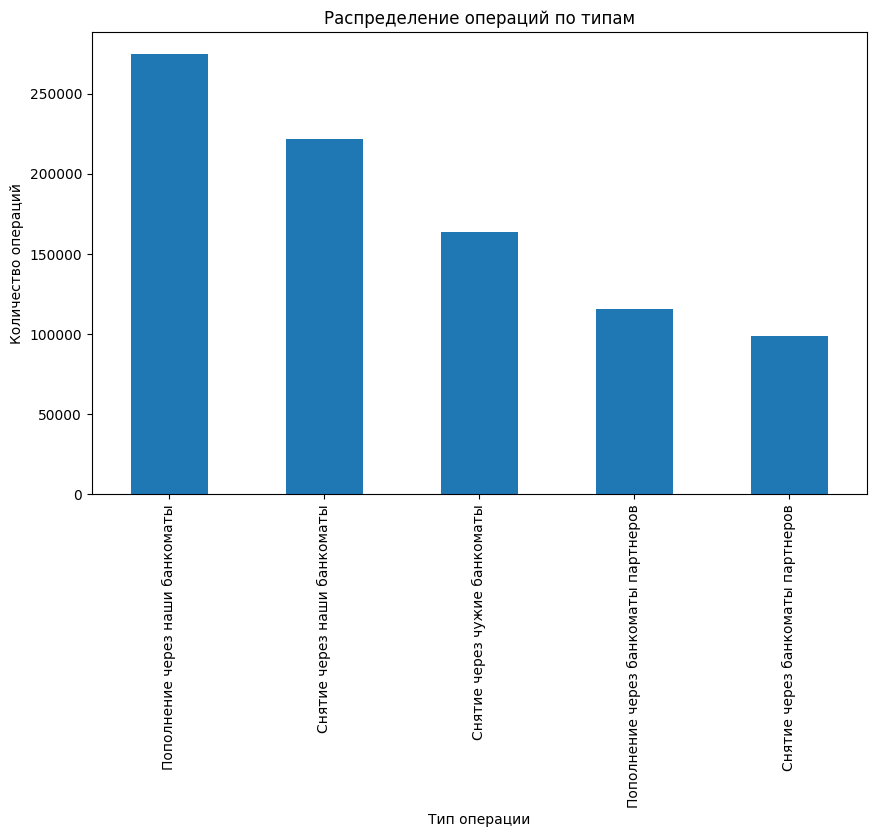

In [28]:
plt.figure(figsize=(10, 6))
data['OPERATION_TYPE'].value_counts().plot(kind='bar')
plt.title('Распределение операций по типам')
plt.xlabel('Тип операции')
plt.ylabel('Количество операций')
plt.show()

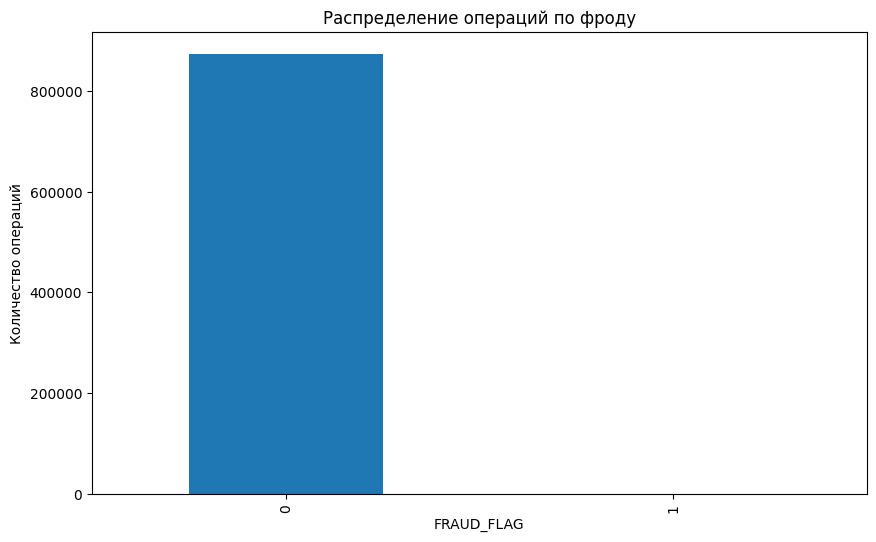

In [29]:
plt.figure(figsize=(10, 6))
data['FRAUD_FLAG'].value_counts().plot(kind='bar')
plt.title('Распределение операций по фроду')
plt.ylabel('Количество операций')
plt.show()

Как можем заметим, у нас явный дисбаланс классов, всего лишь 520 фродовых операций

In [30]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 1. Напишите запрос, который показывает динамику оборотов и кол-ва операций по банкам в разрезе месяца. Какие можно сделать выводы из полученного результата?

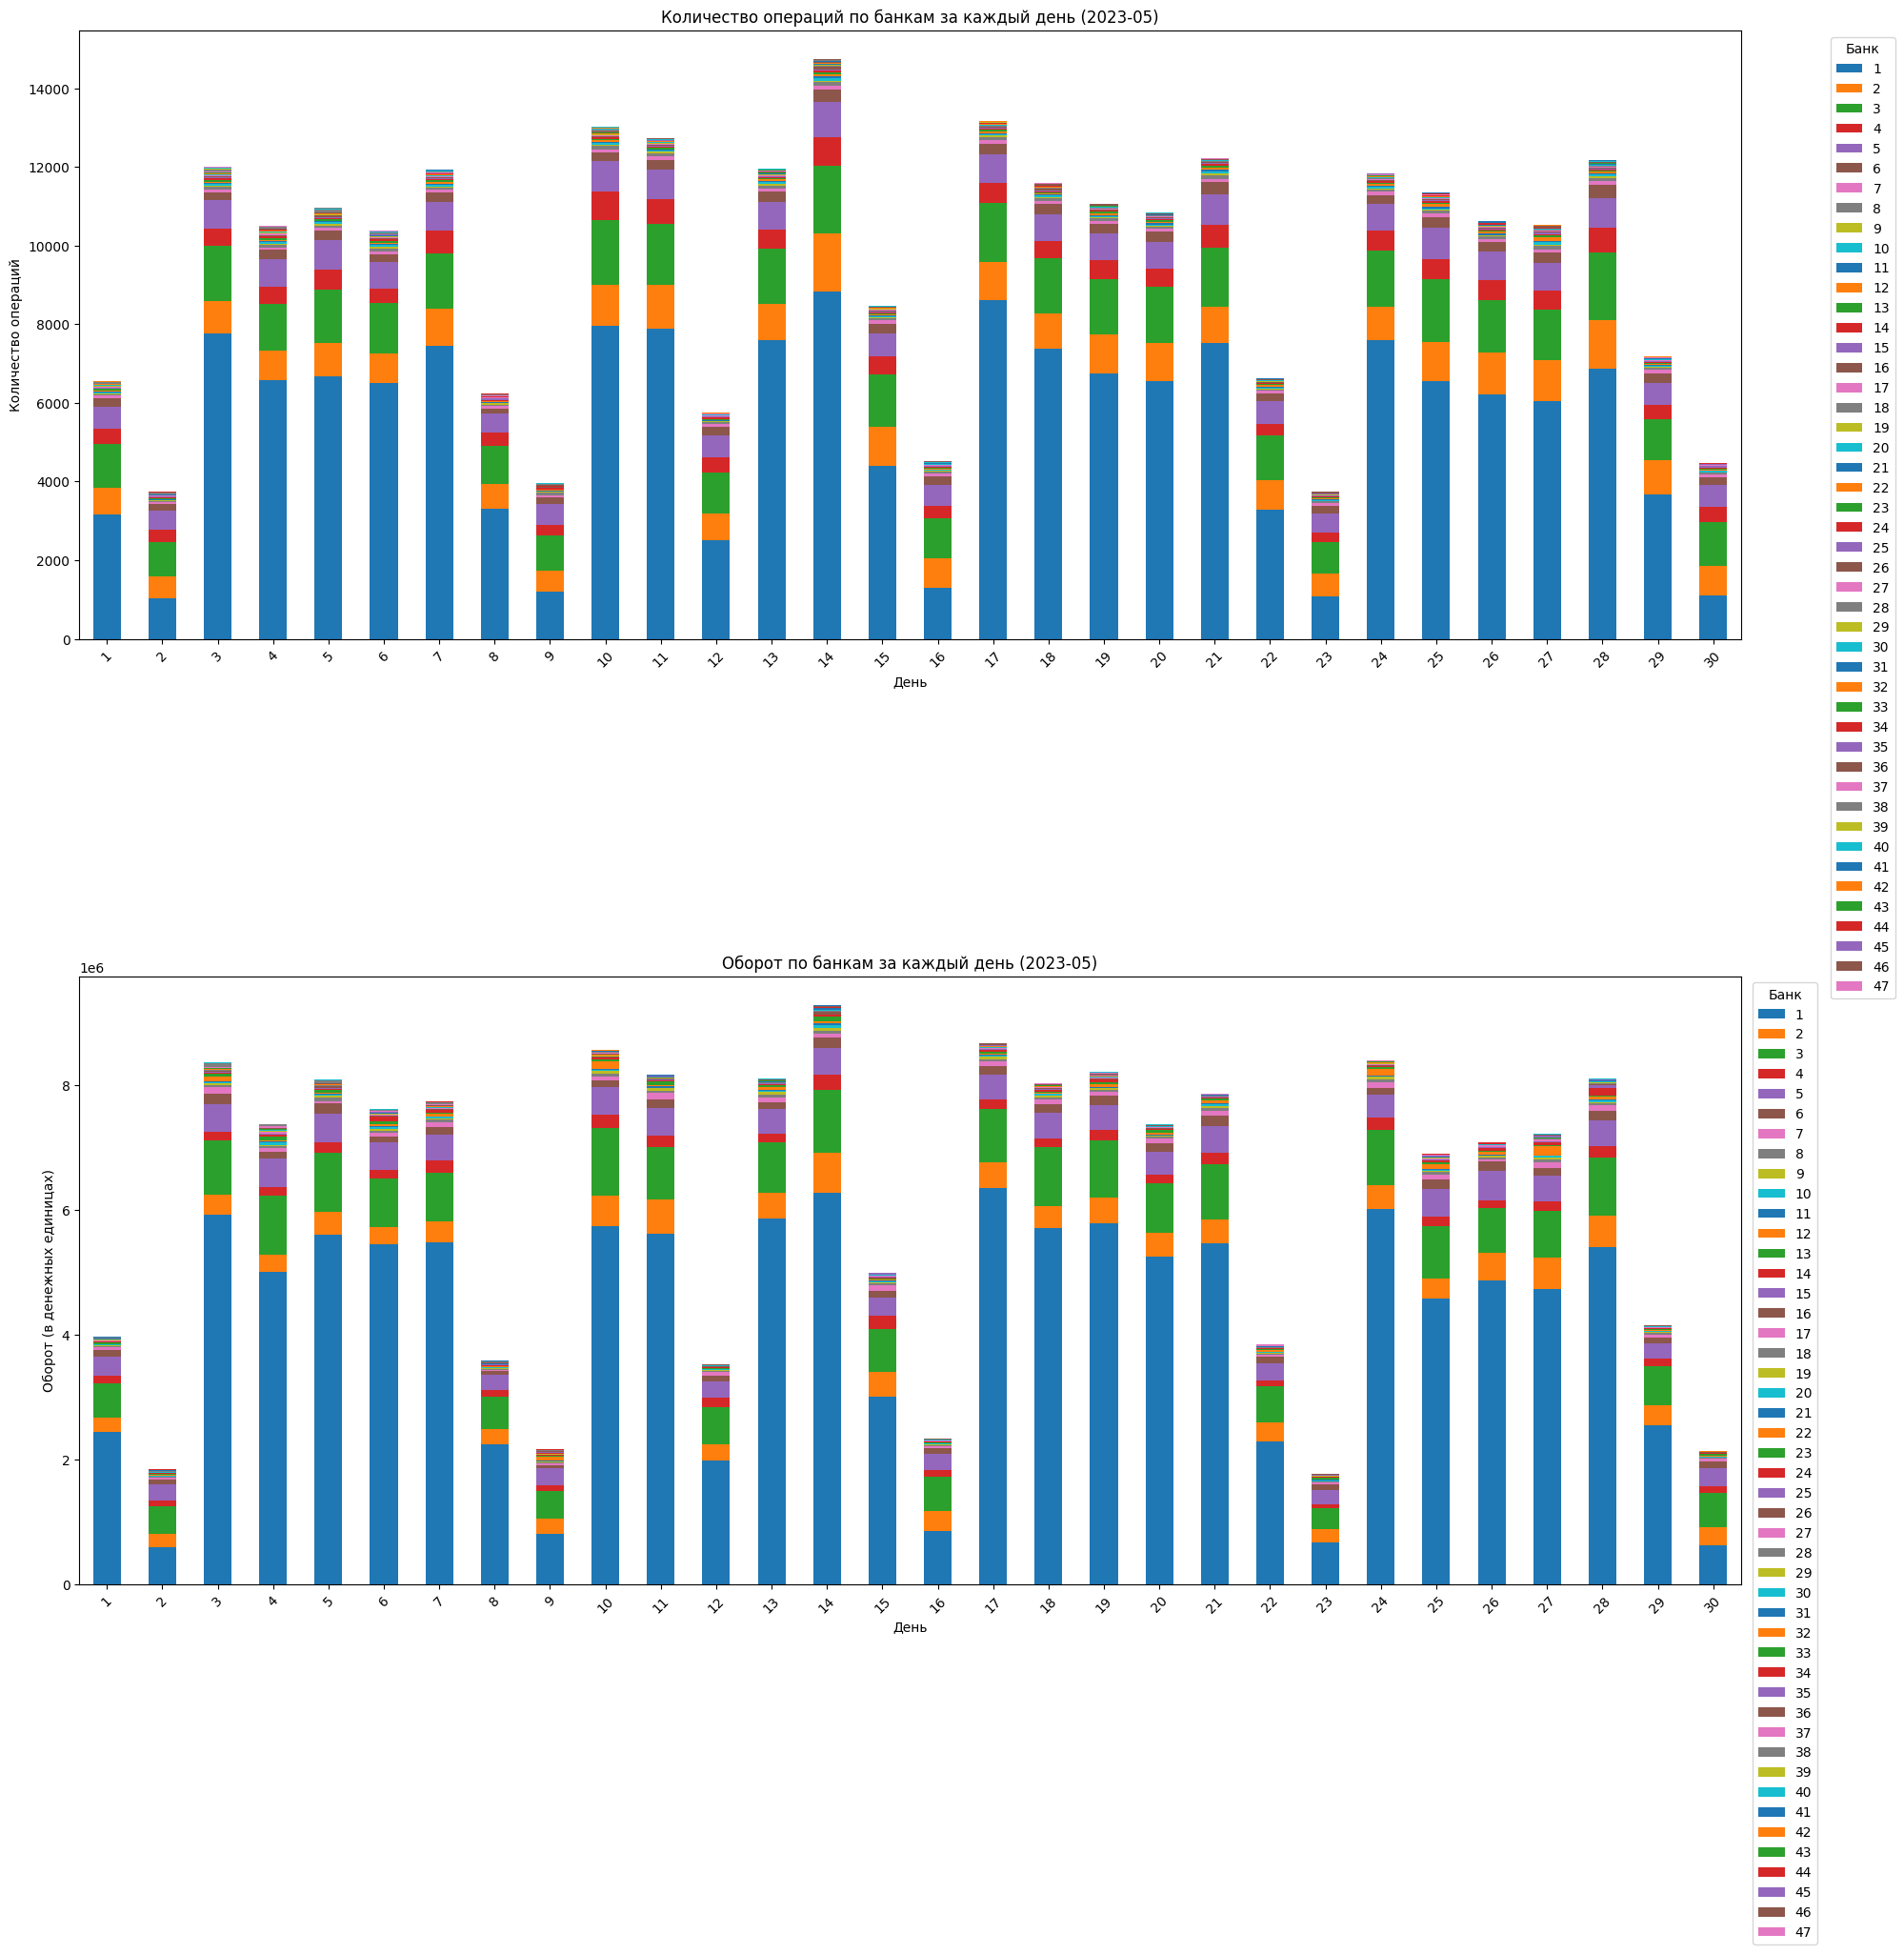

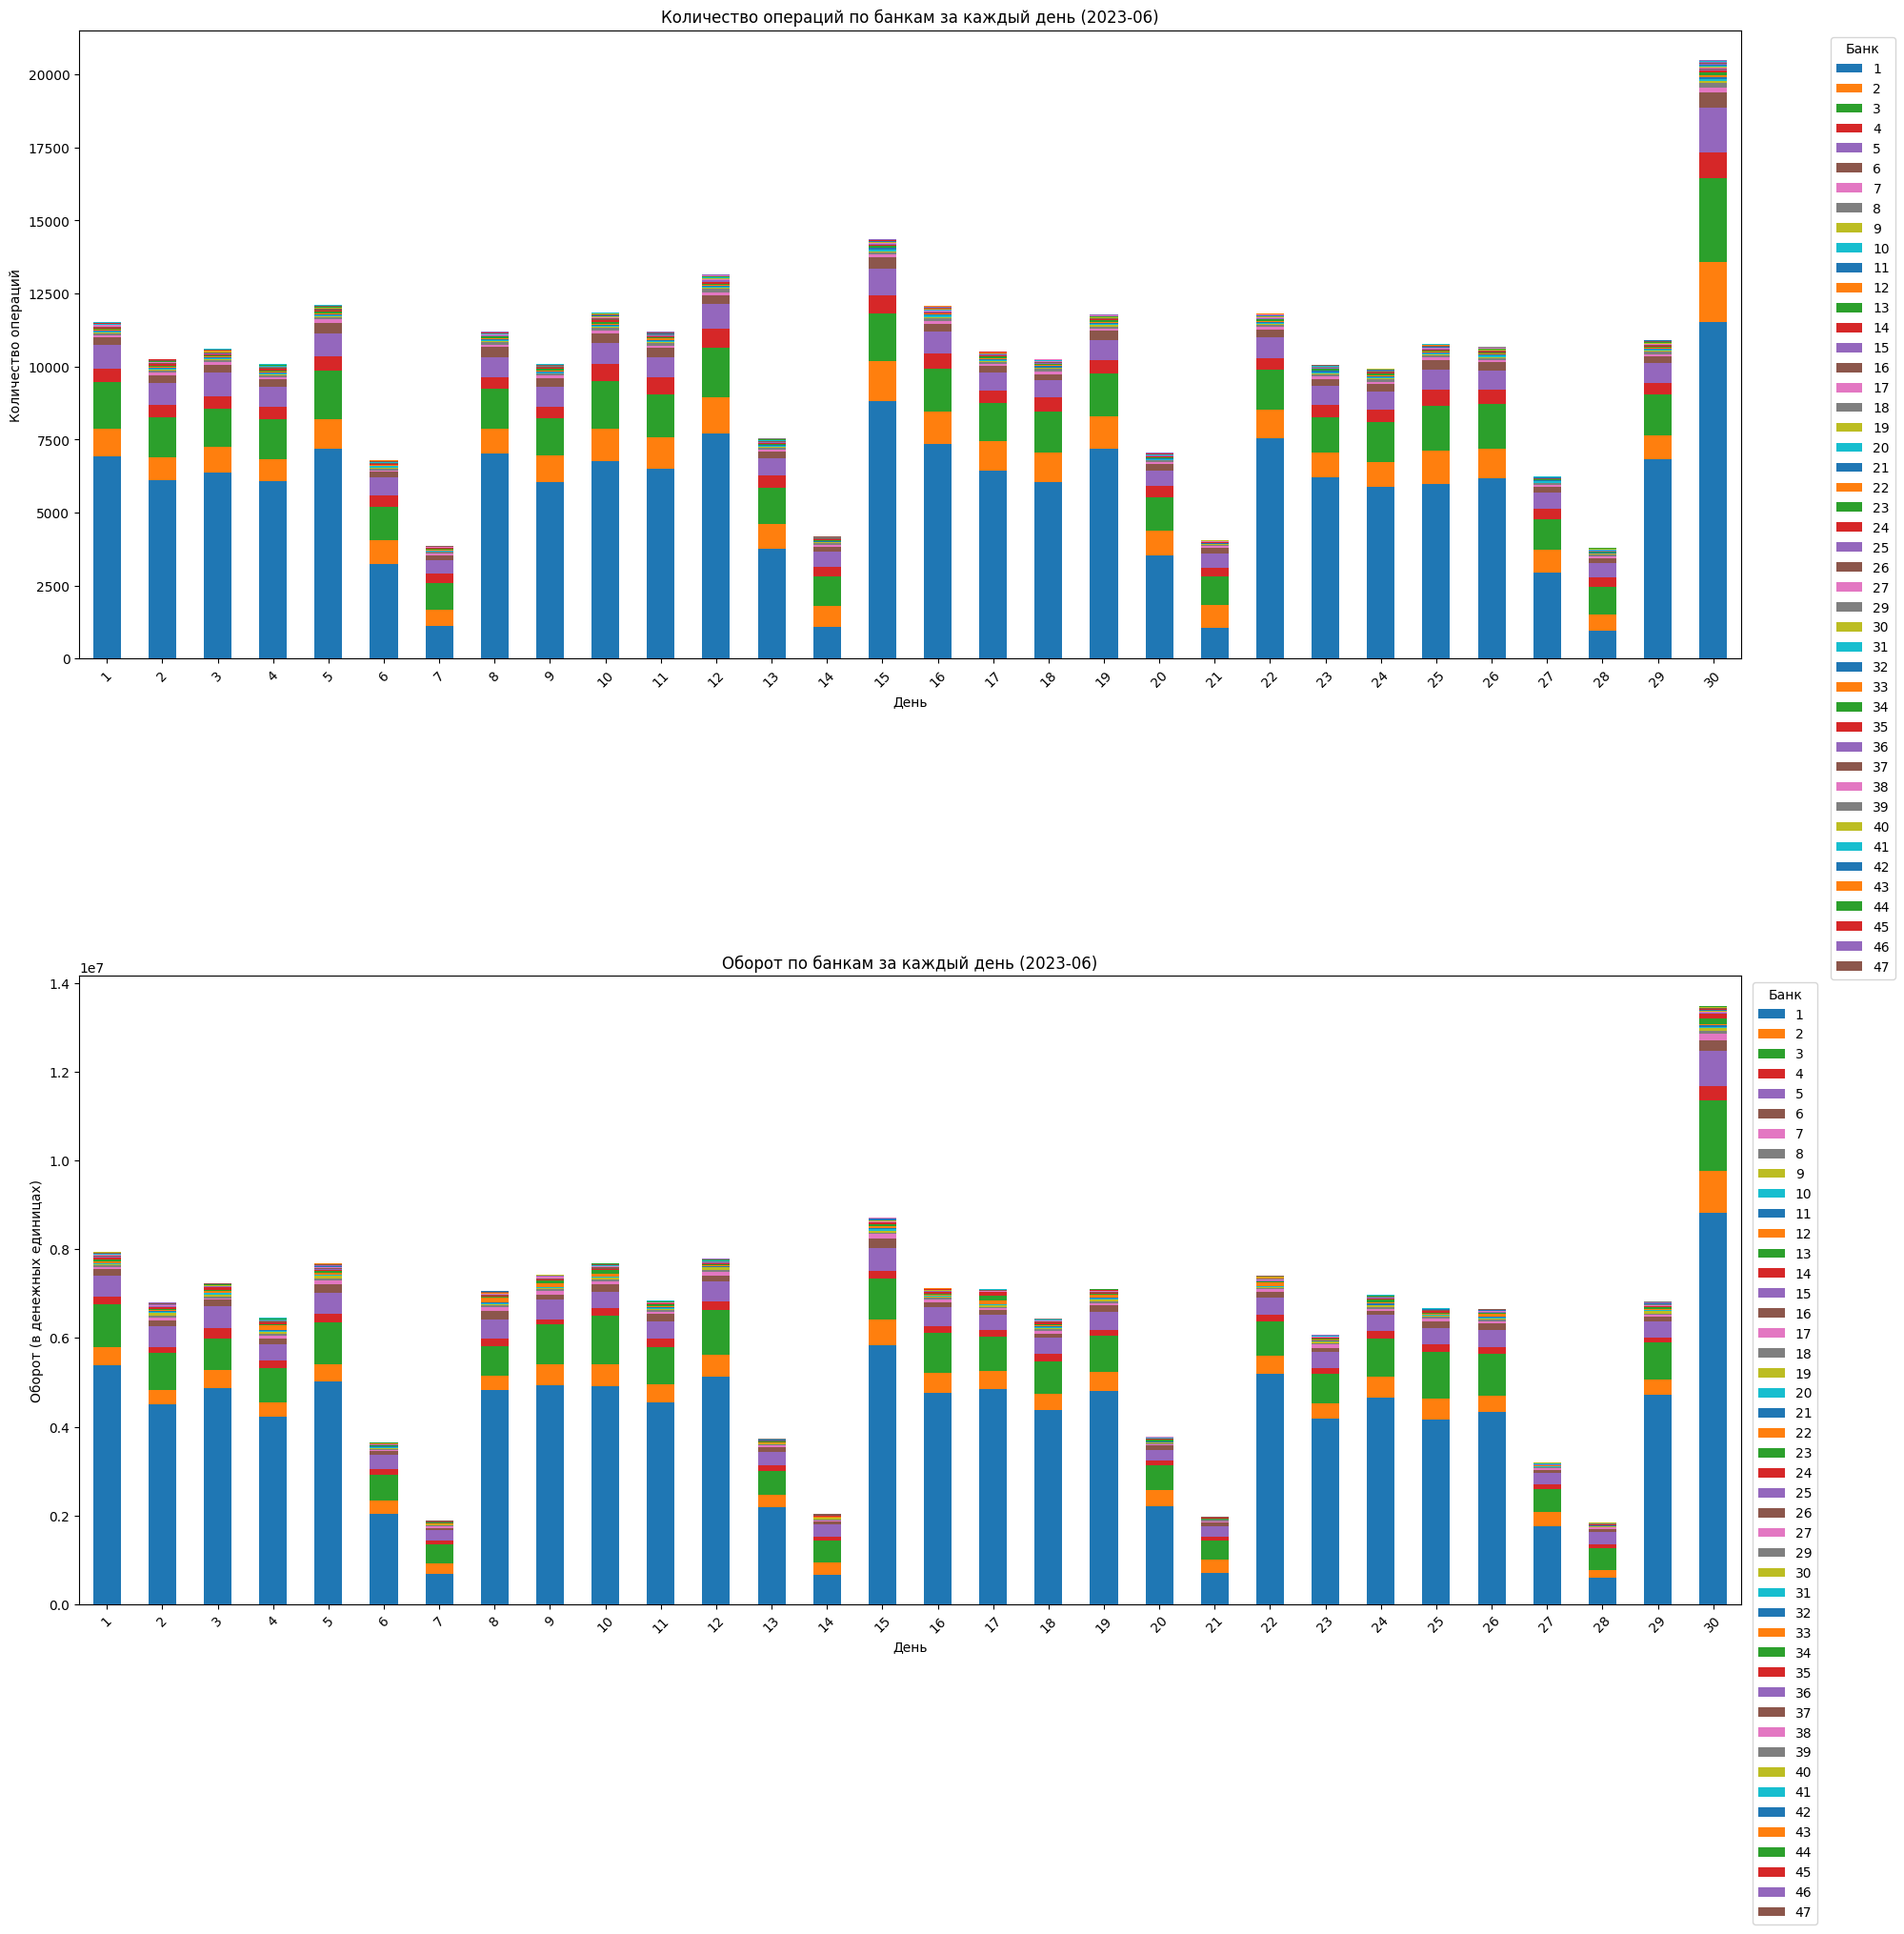

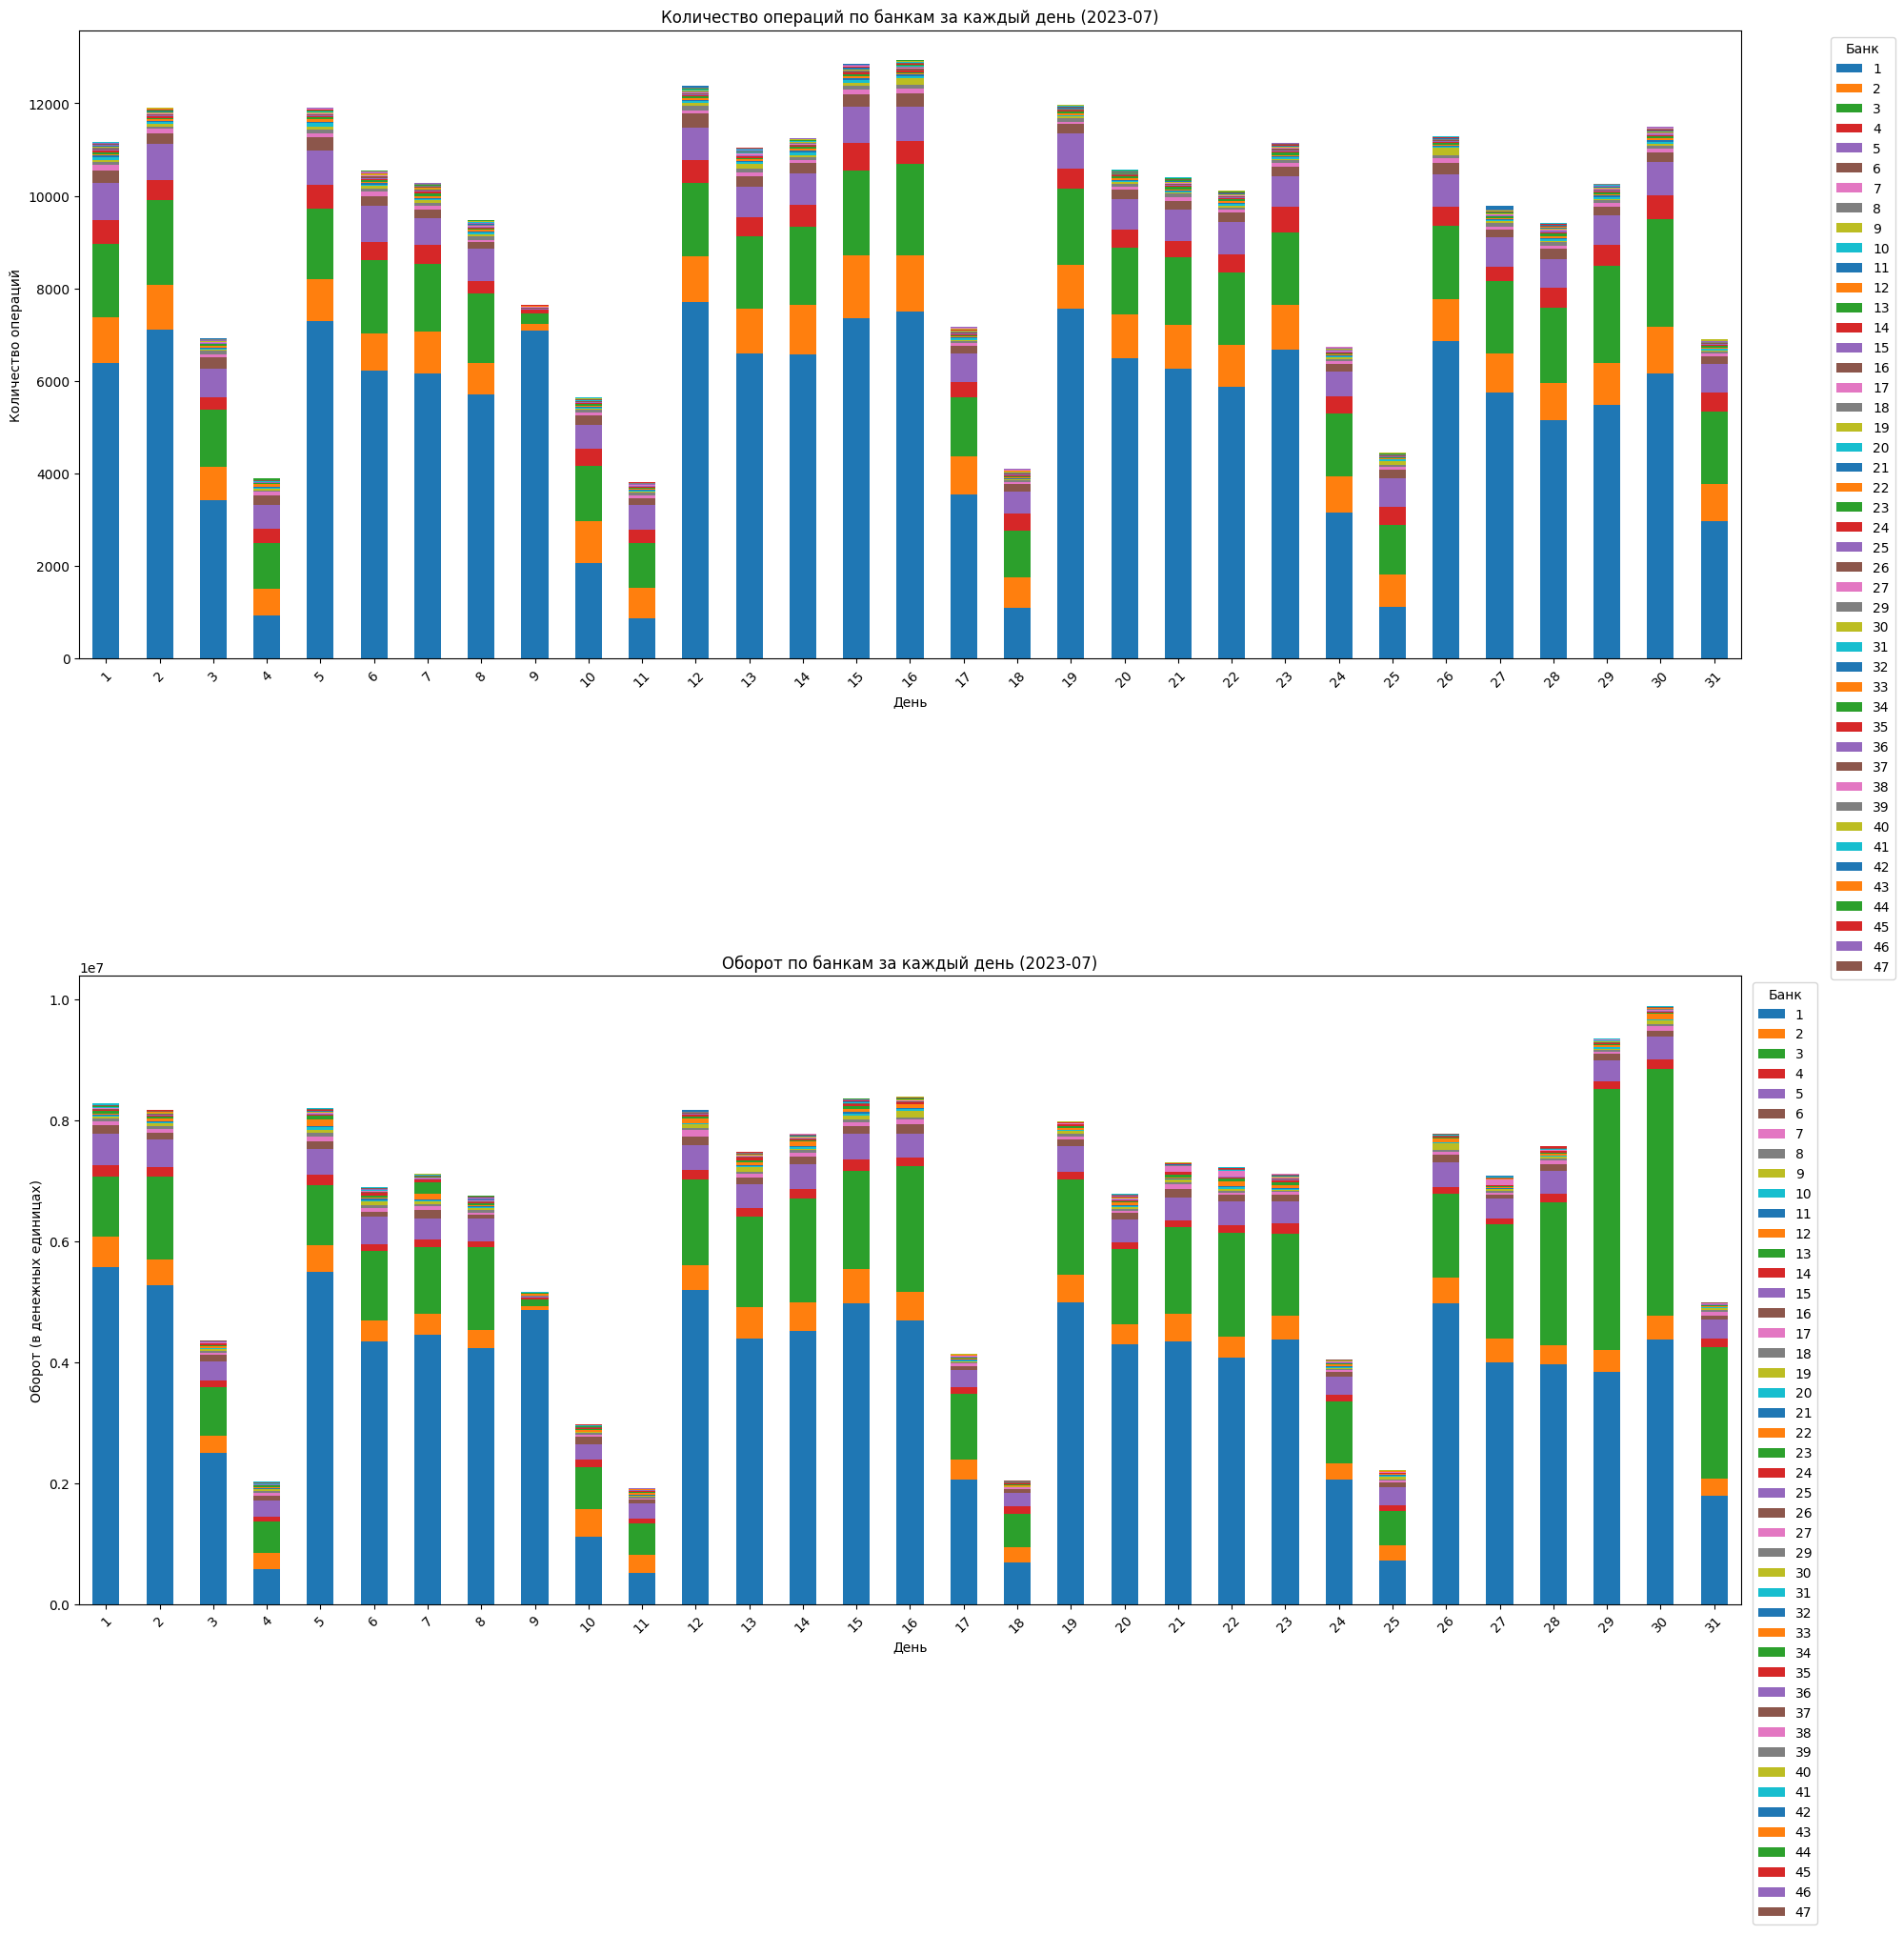

In [36]:
data['TIME'] = pd.to_datetime(data['TIME'])

data['YEAR_MONTH'] = data['TIME'].dt.to_period('M')
data['DAY'] = data['TIME'].dt.day

daily_bank_data = data.groupby(['YEAR_MONTH', 'DAY', 'BANK_ID']).agg(
    total_transactions=('TRANSACTION_ID', 'count'),
    total_amount=('AMOUNT', 'sum')
).reset_index()

unique_months = daily_bank_data['YEAR_MONTH'].unique()

for month in unique_months:
    monthly_data = daily_bank_data[daily_bank_data['YEAR_MONTH'] == month]

    pivot_data_transactions = monthly_data.pivot(index='DAY', columns='BANK_ID', values='total_transactions').fillna(0)
    pivot_data_amount = monthly_data.pivot(index='DAY', columns='BANK_ID', values='total_amount').fillna(0)
    
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))
    
    pivot_data_transactions.plot(kind='bar', stacked=True, ax=axes[0])
    axes[0].set_title(f'Количество операций по банкам за каждый день ({month})')
    axes[0].set_xlabel('День')
    axes[0].set_ylabel('Количество операций')
    axes[0].legend(title='Банк', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].tick_params(axis='x', rotation=45)
    
    pivot_data_amount.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title(f'Оборот по банкам за каждый день ({month})')
    axes[1].set_xlabel('День')
    axes[1].set_ylabel('Оборот (в денежных единицах)')
    axes[1].legend(title='Банк', bbox_to_anchor=(1.05, 1), loc='upper right')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

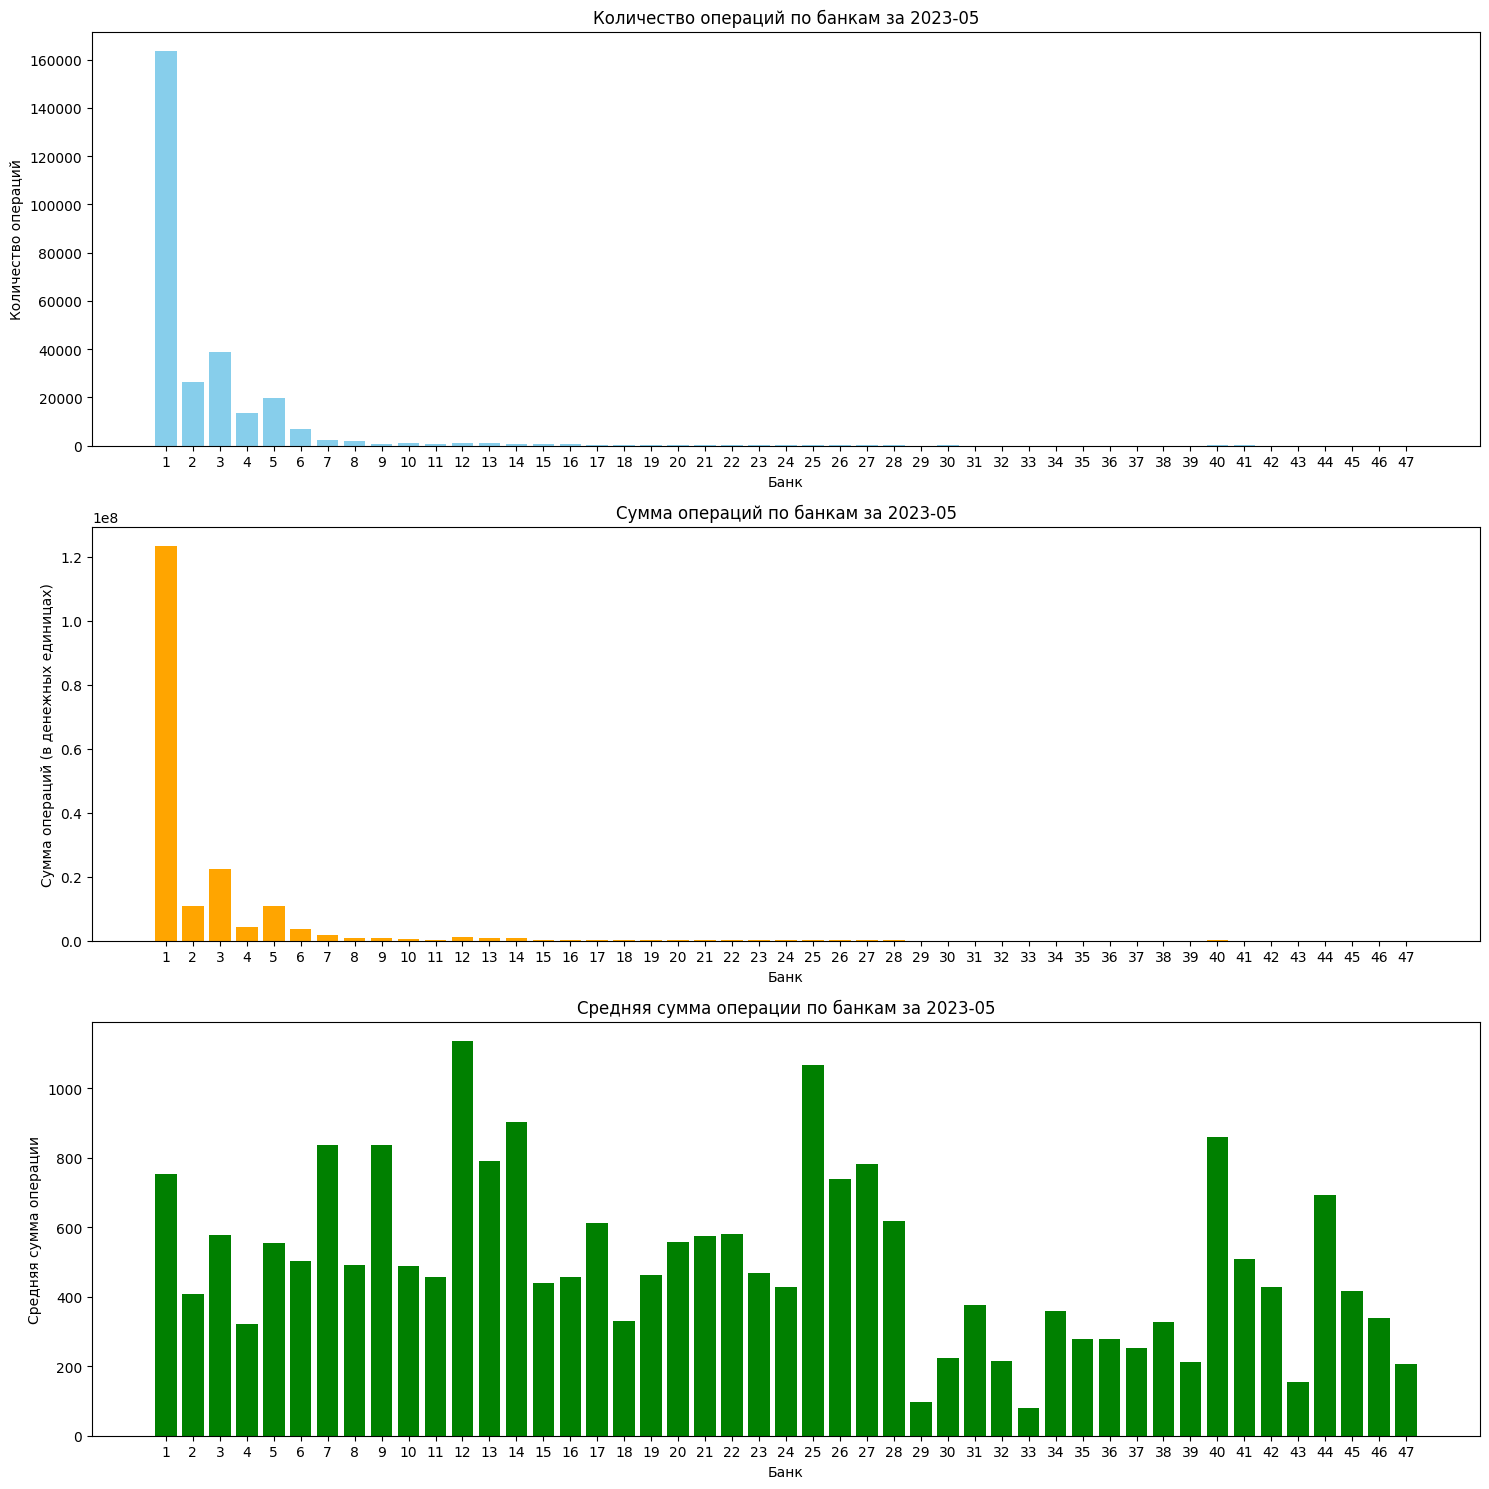

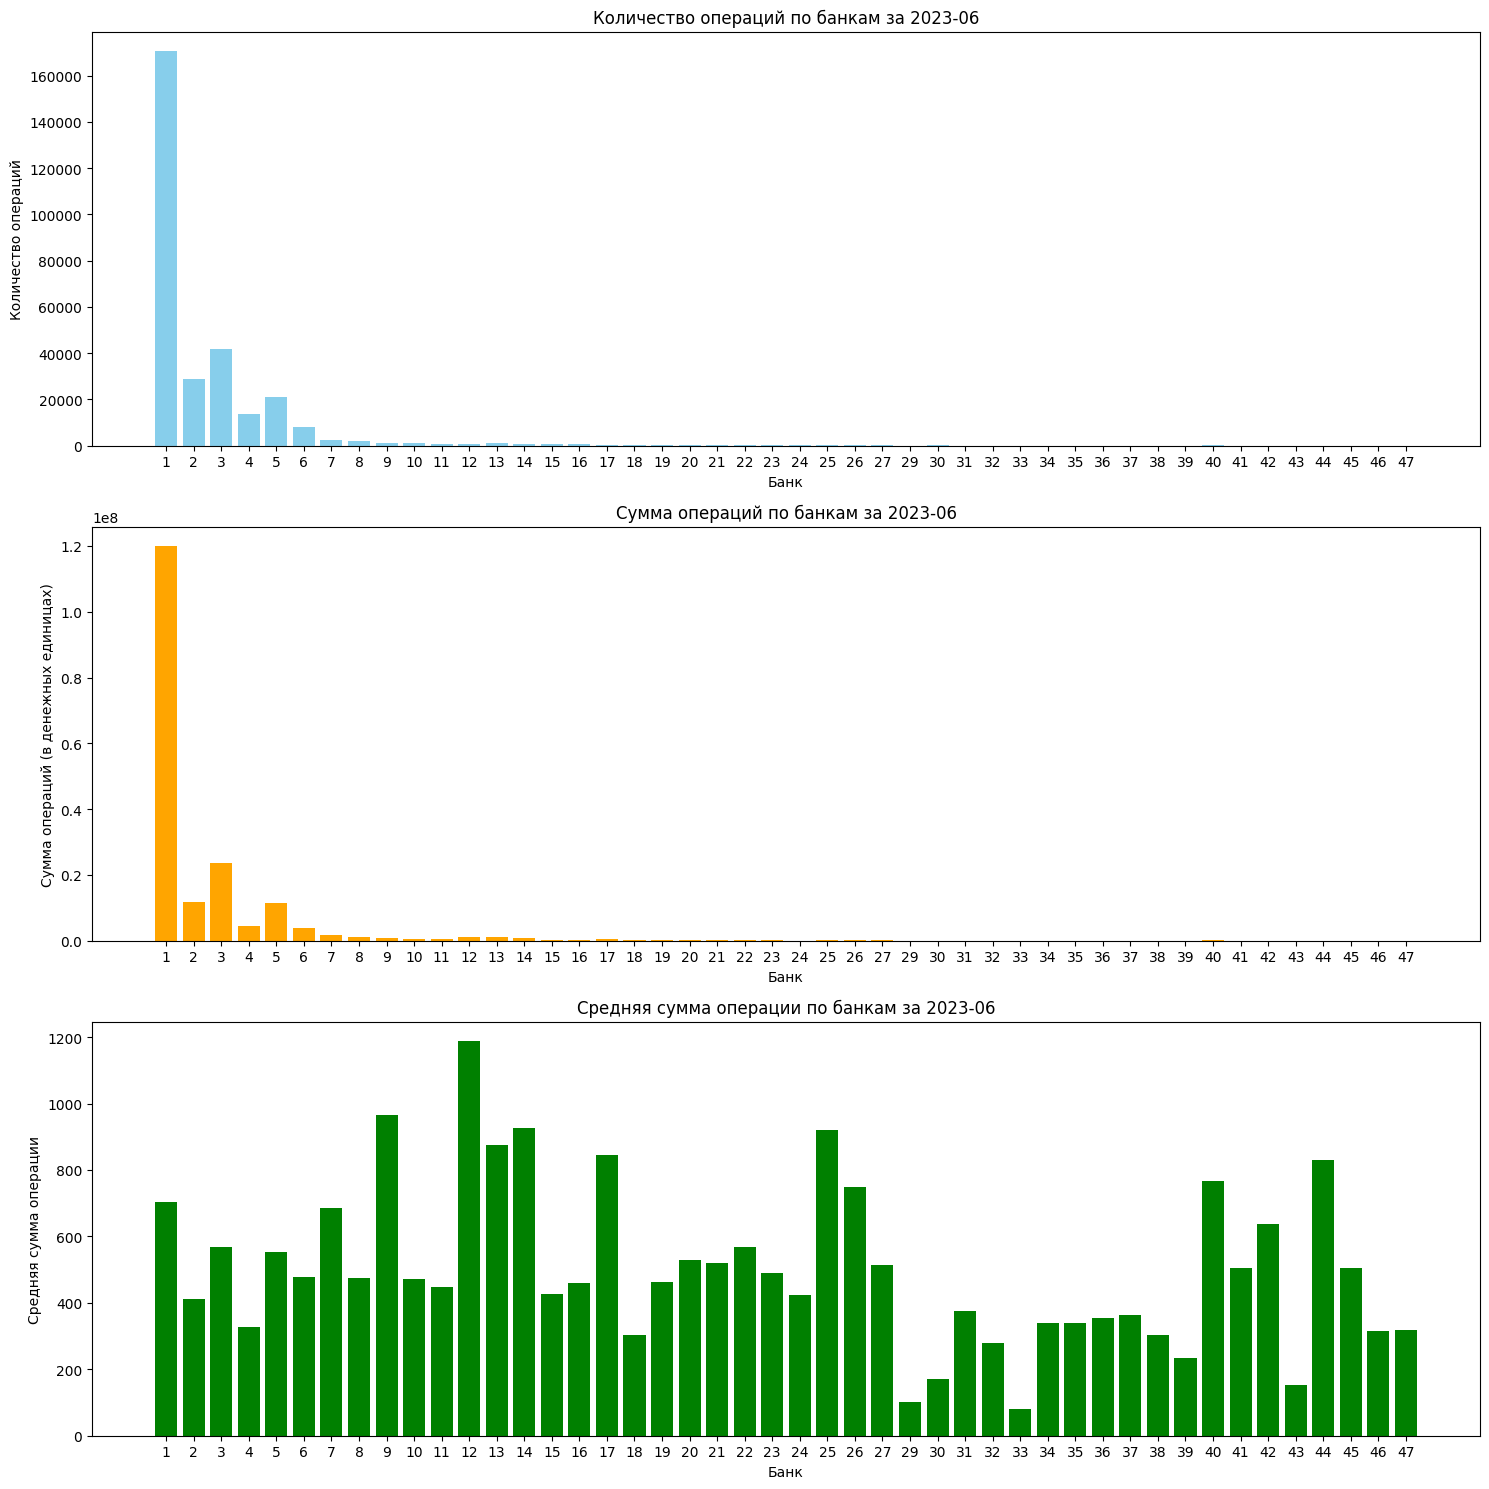

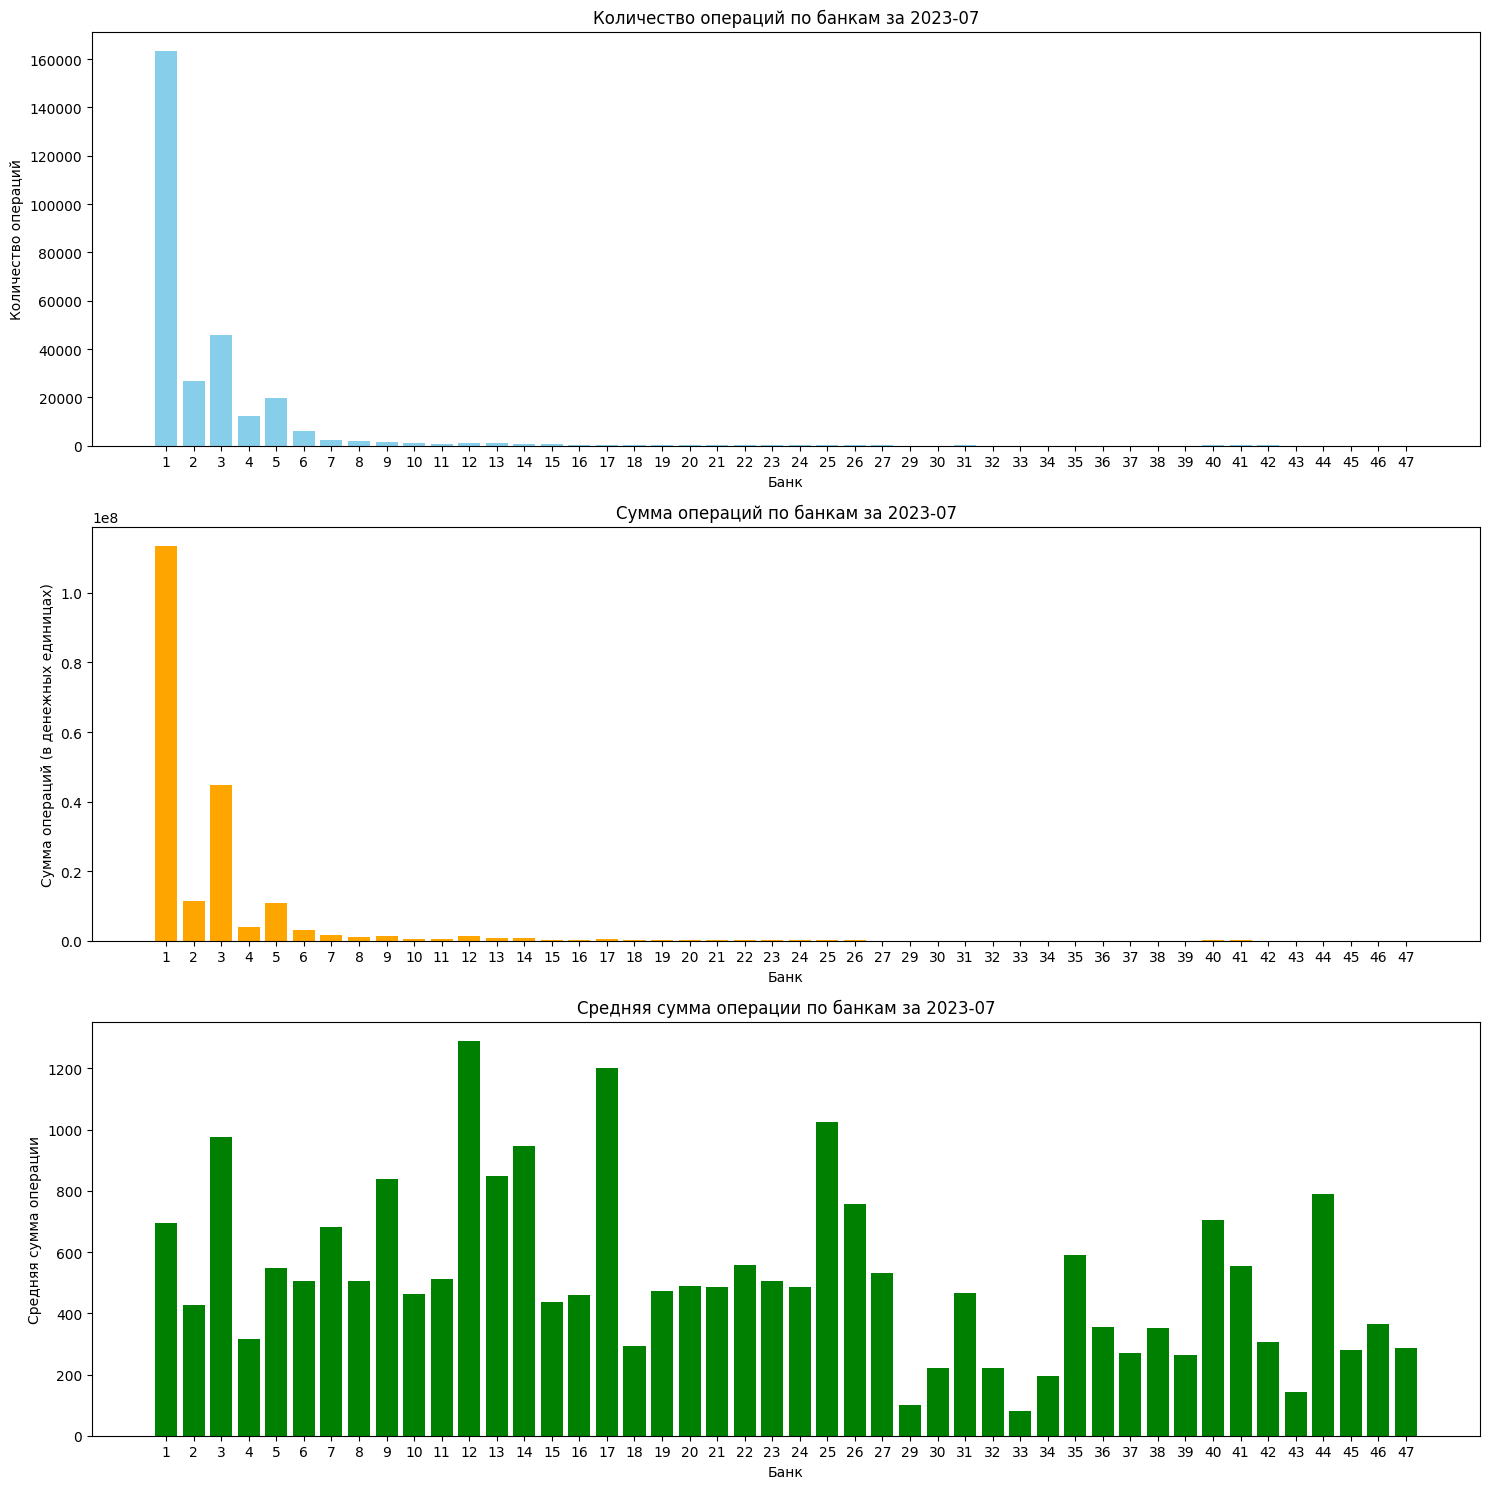

In [37]:
data['TIME'] = pd.to_datetime(data['TIME'])

data['YEAR_MONTH'] = data['TIME'].dt.to_period('M')

monthly_bank_data = data.groupby(['BANK_ID', 'YEAR_MONTH']).agg(
    total_transactions=('TRANSACTION_ID', 'count'),
    total_amount=('AMOUNT', 'sum'),
    average_amount=('AMOUNT', 'mean')
).reset_index()

unique_months = monthly_bank_data['YEAR_MONTH'].unique()

for month in unique_months:
    monthly_data = monthly_bank_data[monthly_bank_data['YEAR_MONTH'] == month]

    # first_5_banks = monthly_data['BANK_ID'].unique()[:5]
    # monthly_data = monthly_data[~monthly_data['BANK_ID'].isin(first_5_banks)]
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    
    axes[0].bar(monthly_data['BANK_ID'].astype(str), monthly_data['total_transactions'], color='skyblue')
    axes[0].set_title(f'Количество операций по банкам за {month}')
    axes[0].set_xlabel('Банк')
    axes[0].set_ylabel('Количество операций')
    
    axes[1].bar(monthly_data['BANK_ID'].astype(str), monthly_data['total_amount'], color='orange')
    axes[1].set_title(f'Сумма операций по банкам за {month}')
    axes[1].set_xlabel('Банк')
    axes[1].set_ylabel('Сумма операций (в денежных единицах)')
    
    axes[2].bar(monthly_data['BANK_ID'].astype(str), monthly_data['average_amount'], color='green')
    axes[2].set_title(f'Средняя сумма операции по банкам за {month}')
    axes[2].set_xlabel('Банк')
    axes[2].set_ylabel('Средняя сумма операции')
    
    plt.tight_layout()
    plt.show()

На основе представленных графиков можно сделать следующие выводы:

- **Количество операций**: В каждом месяце наблюдается значительное количество операций, сосредоточенных в первых нескольких банках. Можно сделать вывод, что первый 5 банков имеют доминирующее положение на рынке.

- **Сумма операций**: Суммы операций также сосредоточены в первых банках, что подтверждает их значительное влияние на рынок.

- **Средняя сумма операций**: Средняя сумма операций варьируется по банкам, но в целом распределение более равномерное по сравнению с количеством и общей суммой операций. Это может указывать на то, что хотя крупные банки обрабатывают больше операций, средняя сумма транзакции может быть сопоставимой с другими банками.

- **Стабильность**: В течение трех месяцев наблюдается стабильность в распределении операций и оборотов по банкам, следовательно не было каких то форс мажорных ситуаций

# 2. Напишите запрос, показывающий процентный рост операций в разрезе банка, от месяца к месяцу. Какой это был банк, какой тип операций и в каком месяце максимальный рост в % и в номинальных значениях оборота. 

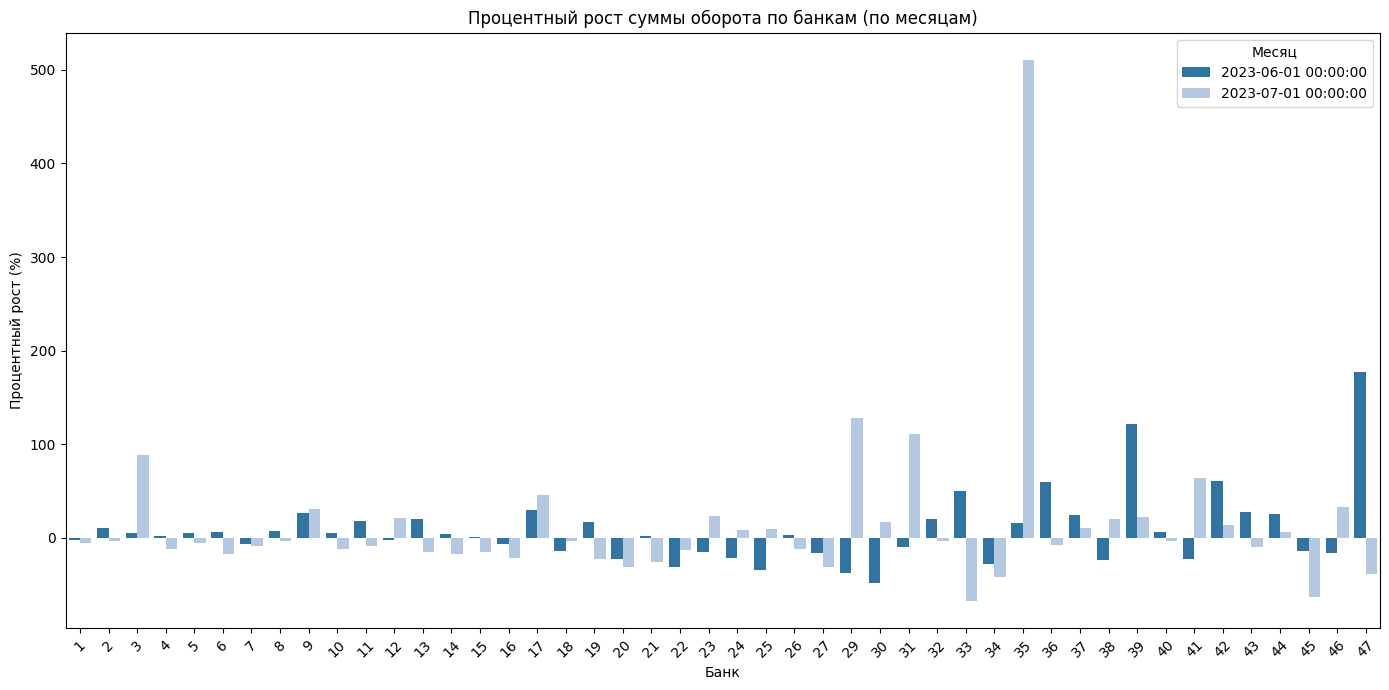

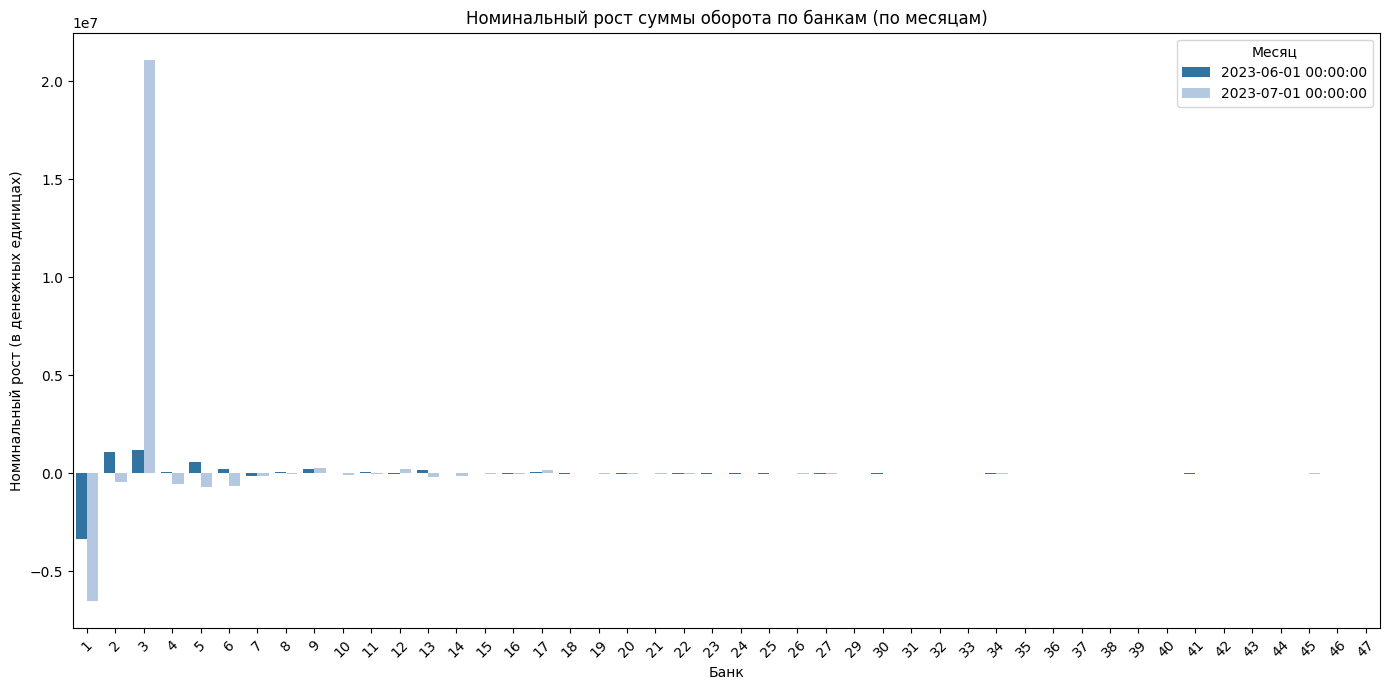

In [38]:
monthly_bank_data['YEAR_MONTH'] = pd.to_datetime(monthly_bank_data['YEAR_MONTH'].astype(str))

monthly_bank_data = monthly_bank_data.sort_values(['YEAR_MONTH', 'BANK_ID'])
monthly_bank_data['transaction_growth_pct'] = monthly_bank_data.groupby('BANK_ID')['total_transactions'].pct_change() * 100
monthly_bank_data['amount_growth_pct'] = monthly_bank_data.groupby('BANK_ID')['total_amount'].pct_change() * 100
monthly_bank_data['amount_growth_nominal'] = monthly_bank_data.groupby('BANK_ID')['total_amount'].diff()

monthly_growth = monthly_bank_data.dropna(subset=['transaction_growth_pct', 'amount_growth_pct', 'amount_growth_nominal'])

plt.figure(figsize=(14, 7))
sns.barplot(
    data=monthly_growth,
    x='BANK_ID',
    y='amount_growth_pct',
    hue='YEAR_MONTH',
    palette='tab20',
    order=sorted(monthly_growth['BANK_ID'].unique())
)
plt.title('Процентный рост суммы оборота по банкам (по месяцам)')
plt.xlabel('Банк')
plt.ylabel('Процентный рост (%)')
plt.xticks(rotation=45)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(
    data=monthly_growth,
    x='BANK_ID',
    y='amount_growth_nominal',
    hue='YEAR_MONTH',
    palette='tab20',
    order=sorted(monthly_growth['BANK_ID'].unique())
)
plt.title('Номинальный рост суммы оборота по банкам (по месяцам)')
plt.xlabel('Банк')
plt.ylabel('Номинальный рост (в денежных единицах)')
plt.xticks(rotation=45)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

In [47]:
bank_35_growth = monthly_bank_data[monthly_bank_data['BANK_ID'] == 35][['YEAR_MONTH', 'amount_growth_pct', 'total_amount']]

bank_3_growth = monthly_bank_data[monthly_bank_data['BANK_ID'] == 3][['YEAR_MONTH', 'amount_growth_nominal', 'total_amount']]

bank_1_growth = monthly_bank_data[monthly_bank_data['BANK_ID'] == 1][['YEAR_MONTH', 'amount_growth_nominal', 'total_amount']]

print("Процентный рост банка №35 по месяцам:")
print(bank_35_growth)

print("Номинальный рост банка №3 по месяцам:")
print(bank_3_growth)

print("Номинальный рост банка №1 по месяцам:")
print(bank_1_growth)

Процентный рост банка №35 по месяцам:
    YEAR_MONTH  amount_growth_pct  total_amount
100 2023-05-01                NaN          6990
101 2023-06-01          16.165951          8120
102 2023-07-01         510.837438         49600
Номинальный рост банка №3 по месяцам:
  YEAR_MONTH  amount_growth_nominal  total_amount
6 2023-05-01                    NaN      22473630
7 2023-06-01              1208600.0      23682230
8 2023-07-01             21089220.0      44771450
Номинальный рост банка №1 по месяцам:
  YEAR_MONTH  amount_growth_nominal  total_amount
0 2023-05-01                    NaN     123245440
1 2023-06-01             -3339020.0     119906420
2 2023-07-01             -6516270.0     113390150


In [49]:
monthly_bank_data = monthly_bank_data.sort_values(['BANK_ID', 'YEAR_MONTH'])
monthly_bank_data['transaction_growth_pct'] = monthly_bank_data.groupby('BANK_ID')['total_transactions'].pct_change() * 100
monthly_bank_data['amount_growth_pct'] = monthly_bank_data.groupby('BANK_ID')['total_amount'].pct_change() * 100
monthly_bank_data['amount_growth_nominal'] = monthly_bank_data.groupby('BANK_ID')['total_amount'].diff()

max_pct_growth = monthly_bank_data.loc[monthly_bank_data['amount_growth_pct'].idxmax()]
max_nominal_growth = monthly_bank_data.loc[monthly_bank_data['amount_growth_nominal'].idxmax()]

bank_max_pct = max_pct_growth['BANK_ID']
month_max_pct = max_pct_growth['YEAR_MONTH'].strftime('%Y-%m')
amount_max_pct = max_pct_growth['amount_growth_pct']

bank_max_nominal = max_nominal_growth['BANK_ID']
month_max_nominal = max_nominal_growth['YEAR_MONTH'].strftime('%Y-%m')
amount_max_nominal = max_nominal_growth['amount_growth_nominal']

max_pct_data = data[(data['BANK_ID'] == bank_max_pct) & (data['TIME'].dt.strftime('%Y-%m') == month_max_pct)]
max_nominal_data = data[(data['BANK_ID'] == bank_max_nominal) & (data['TIME'].dt.strftime('%Y-%m') == month_max_nominal)]

operation_type_pct = max_pct_data['OPERATION_TYPE'].mode().values[0]
operation_type_nominal = max_nominal_data['OPERATION_TYPE'].mode().values[0]

cities_max_pct = max_pct_data['CITY'].unique()
cities_max_nominal = max_nominal_data['CITY'].unique()

print(f"Максимальный процентный рост оборота:")
print(f"Банк: {bank_max_pct}, Месяц: {month_max_pct}, Рост: {amount_max_pct:.2f}%")
print(f"Наиболее частый тип операции: {operation_type_pct}")
print(f"Города: {', '.join(cities_max_pct)}\n")

print(f"Максимальный номинальный рост оборота:")
print(f"Банк: {bank_max_nominal}, Месяц: {month_max_nominal}, Рост: {amount_max_nominal}")
print(f"Наиболее частый тип операции: {operation_type_nominal}")
print(f"Города: {', '.join(cities_max_nominal)}")

Максимальный процентный рост оборота:
Банк: 35, Месяц: 2023-07, Рост: 510.84%
Наиболее частый тип операции: Снятие через чужие банкоматы
Города: Оренбург, Новосибирск, Волгоград, Уфа, Habarovsk, Курган, Москва, Томск, Архангельск, Ставраполь, Тамбов, Elabuga, Электросталь

Максимальный номинальный рост оборота:
Банк: 3, Месяц: 2023-07, Рост: 21089220.0
Наиболее частый тип операции: Пополнение через банкоматы партнеров
Города: Великий Новгород, Korsakov, Балашиха, Барнаул, Владивосток, Хабаровск, Otradnyi, Beloretsk, Магнитогорск, Krasnyi bor p, Alekseevka, Саранск, Череповец, Ижевск, Шахты, Тюмень, Санкт-Петербург, Liantor, Москва, Skovorodino, Химки, Polysaevo, Улан-Удэ, Курган, Krasnokamsk, Griazi, Pridorozhnyi, Sosenskoe p, Новороссийск, Chaikovskii, Вологда, Сочи, Невинномысск, Екатеринбург, Shelekhov, Новокузнецк, Тула, Электросталь, Visa direct, Братск, Первоуральск, Смоленск, Zelenodolsk, Томск, Spassk dalnii, Саратов, Magistralnyi, Magdagachi pg, Ковров, Волгоград, Пугачёв, Kho

На основе представленных данных можно сделать следующие выводы:

- Максимальный процентный рост оборота в банке №35 в июле 2023 года (510.84%) может указывать на резкий всплеск активности, например, это может быть связано с сезонными факторами, акциями или изменениями в политике банка.

- Максимальный номинальный рост оборота в банке №3 в том же месяце (21089220.0) указывает на значительное увеличение объема операций, особенно "Пополнение через банкоматы партнеров". Это может свидетельствовать о расширении клиентской базы или увеличении среднего размера транзакций или других операций.

# 3. Проведите анализ клиентов с FRAUD_FLAG = 1 и попробуйте понять, какие характеристики объединяют их.
Напишите запрос, позволяющий найти аналогичных клиентов, но с FRAUD_FLAG = 0.
Посчитайте долю операций таких клиентов от общей доли соответствующего типа операций в разрезе месяца.

In [50]:
fraud_banks = data[data['FRAUD_FLAG'] == 1]['BANK_ID'].value_counts()

print("Банки, в которых были фродовые операции:")
print(fraud_banks)

Банки, в которых были фродовые операции:
BANK_ID
3     295
5     186
6      27
20     11
4       1
Name: count, dtype: int64


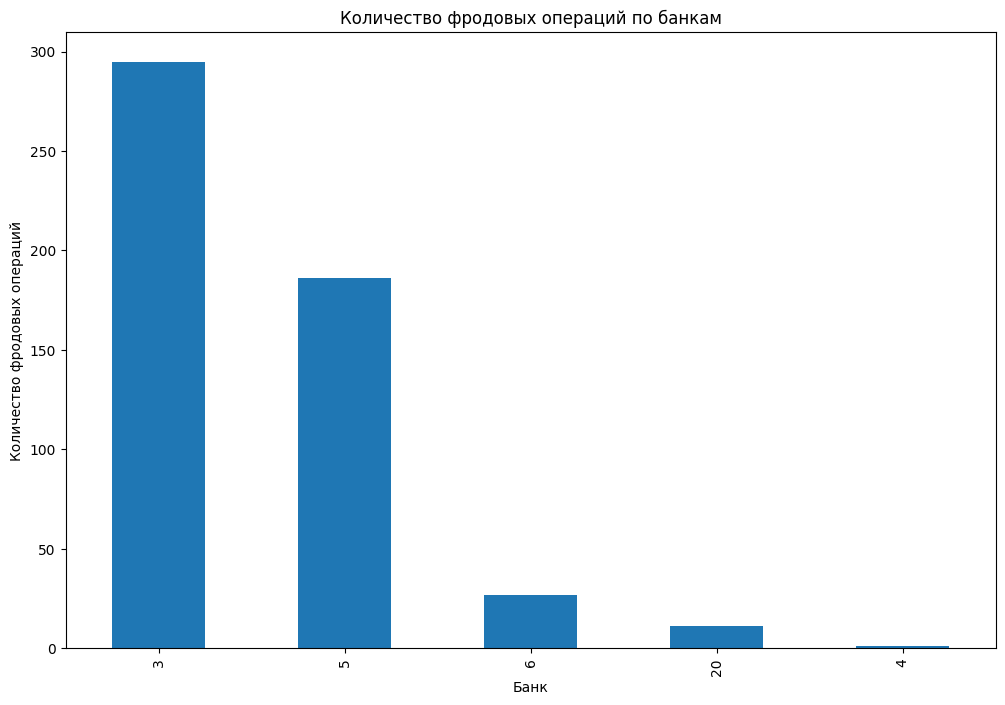

In [51]:
plt.figure(figsize=(12, 8))
fraud_banks.plot(kind='bar')
plt.title('Количество фродовых операций по банкам')
plt.xlabel('Банк')
plt.ylabel('Количество фродовых операций')
plt.show()

In [52]:
fraud_operations = data[data['FRAUD_FLAG'] == 1][['CLIENT_ID', 'CITY', 'TIME', 'BANK_ID', 'AMOUNT']]

print("Информация по клиентам, кто, где и когда производил фродовые операции:")
print(fraud_operations[['CLIENT_ID', 'CITY', 'BANK_ID']].value_counts())

Информация по клиентам, кто, где и когда производил фродовые операции:
CLIENT_ID                                                         CITY          BANK_ID
878845BF4574E76A13D362CD5EC8F0D95CAFFBCDE6E744011B76A8B0AF9E704A  Visa direct   3          22
                                                                  Екатеринбург  3          22
0DBB0A99DB550F7030ED547F7105A61A901CE3A073969605E5345C191C859693  Ukhta         3          20
A05AB2289DA3BD464C78E1A4998788BEE31E8A3D9951B751A8D003B2F8E7A1D6  Пенза         5          17
18D7D8A0C55811587DDA9BC8C6154EAFAEC7A5590D5F9E5A55B2884D898554D7  Griazi        3          13
                                                                                           ..
F7091438D3BB0E620130F83E469421055A5F6A05B89609EDD38EBBB1E32C4A34  Пенза         3           2
DC94535434CE39472C2BEB7336679FE03FA299E5839F39B4455B2F49CB6952F0  Il inka       6           1
46BC66A6F14095CA7CD5D2A74B43EBCCE89ACD5DAFA474F70C91223B7539E3D5  Visa direct   3        

Как мы видим, всего 75 клиентов, которые проводили фродовые операции, и основная доля фродовых операций пришлась на 3 и 5 банк

Проверим поведение этих клиентов

In [89]:
data[(data['FRAUD_FLAG'] == 0) & (data['CLIENT_ID'].isin(data[data['FRAUD_FLAG'] == 1]['CLIENT_ID'].unique()))]

TIME  TRANSACTION_ID  AMOUNT  \
3667   2023-05-02 12:03:57    525393930577     160   
4780   2023-05-01 15:05:43    525477131563     470   
5346   2023-05-01 11:40:06    525487903106     470   
5832   2023-05-01 13:02:16    525493975126      20   
5984   2023-05-01 14:09:05    525495247215      80   
...                    ...             ...     ...   
589065 2023-06-30 19:24:47    540302673307     860   
589338 2023-06-30 19:33:36    540305220086     390   
589961 2023-06-30 19:32:37    540308589507     470   
590242 2023-06-30 16:07:28    540310921708     470   
590660 2023-06-30 16:06:49    540315154379     470   

                                                CLIENT_ID  BANK_ID       CITY  \
3667    0B341BE5A3A32F339BCC957923446E634C78E927FED6C5...        1      Анапа   
4780    EA180F39ECA08387A525DB281B3FA338D8BB7EDC964852...        5  Волгоград   
5346    6DF9E1644CC6E42CE5465040444C3607E7AB628C7C31AF...       20   Норильск   
5832    8A11678B1C8C81E83B1C0F87612AD0469CBDFD494DF121...        3   Смоленск   
5984    1EEC6E5F76135460525CA1FB524A909B45398A7F81FC30...        6  Краснодар   
...                                                   ...      ...        ...   
589065  8A11678B1C8C81E83B1C0F87612AD0469CBDFD494DF121...        3   Смоленск   
589338  8A11678B1C8C81E83B1C0F87612AD0469CBDFD494DF121...        3   Смоленск   
589961  8A11678B1C8C81E83B1C0F87612AD0469CBDFD494DF121...        3   Смоленск   
590242  05E2EA890765095DD2FE49119502E9AD0FBA22C4CD67CC...        5    Батайск   
590660  05E2EA890765095DD2FE49119502E9AD0FBA22C4CD67CC...        5    Батайск   

                              OPERATION_TYPE  FRAUD_FLAG YEAR_MONTH  DAY  \
3667         Пополнение через наши банкоматы           0    2023-05    2   
4780        Снятие через банкоматы партнеров           0    2023-05    1   
5346        Снятие через банкоматы партнеров           0    2023-05    1   
5832        Снятие через банкоматы партнеров           0    2023-05    1   
5984    Пополнение через банкоматы партнеров           0    2023-05    1   
...                                      ...         ...        ...  ...   
589065  Пополнение через банкоматы партнеров           0    2023-06   30   
589338      Снятие через банкоматы партнеров           0    2023-06   30   
589961      Снятие через банкоматы партнеров           0    2023-06   30   
590242      Снятие через банкоматы партнеров           0    2023-06   30   
590660      Снятие через банкоматы партнеров           0    2023-06   30   

        HOUR  MONTH  WEEKDAY  
3667      12      5        1  
4780      15      5        0  
5346      11      5        0  
5832      13      5        0  
5984      14      5        0  
...      ...    ...      ...  
589065    19      6        4  
589338    19      6        4  
589961    19      6        4  
590242    16      6        4  
590660    16      6        4  

[849 rows x 13 columns]

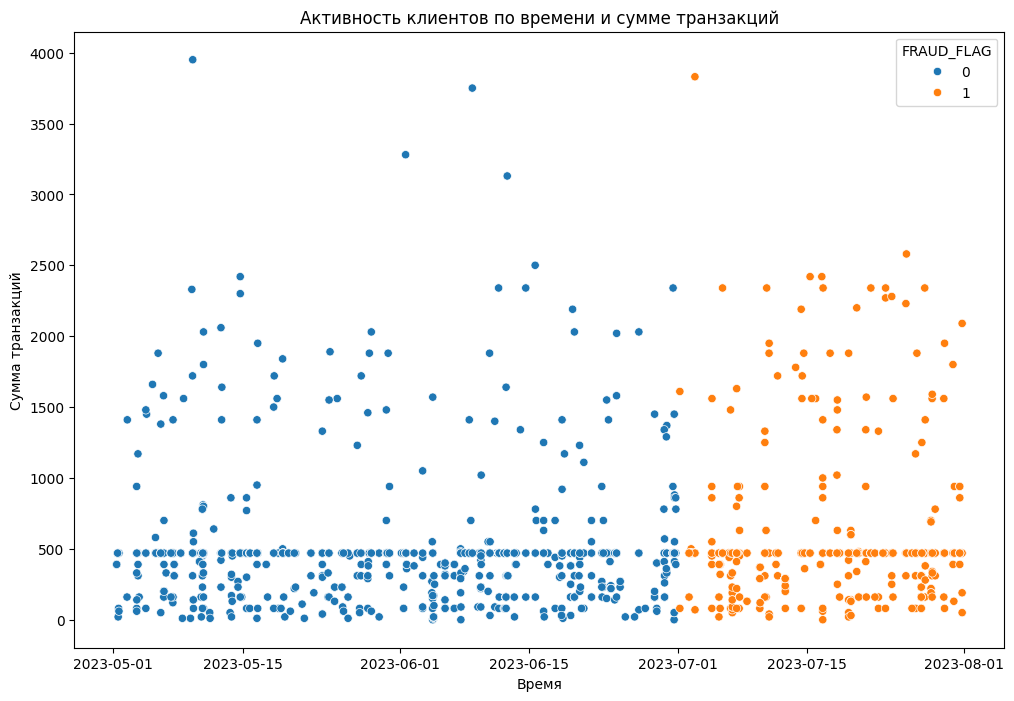

In [90]:
check_clients = data[(data['CLIENT_ID'].isin(data[data['FRAUD_FLAG'] == 1]['CLIENT_ID'].unique()))]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=check_clients, x='TIME', y='AMOUNT', hue='FRAUD_FLAG')
plt.title('Активность клиентов по времени и сумме транзакций')
plt.xlabel('Время')
plt.ylabel('Сумма транзакций')
plt.show()

In [91]:
fraud_clients = data[data['FRAUD_FLAG'] == 1]['CLIENT_ID'].unique()

fraud_and_non_fraud_operations = data[data['CLIENT_ID'].isin(fraud_clients)]

before_july = fraud_and_non_fraud_operations[fraud_and_non_fraud_operations['TIME'] < '2023-07-01']
after_july = fraud_and_non_fraud_operations[fraud_and_non_fraud_operations['TIME'] >= '2023-07-01']

client_bank_usage_before_july = before_july.groupby(['CLIENT_ID', 'BANK_ID', 'FRAUD_FLAG', 'OPERATION_TYPE']).size().reset_index(name='COUNT')

client_bank_usage_after_july = after_july.groupby(['CLIENT_ID', 'BANK_ID', 'FRAUD_FLAG', 'OPERATION_TYPE']).size().reset_index(name='COUNT')

print("Данные по использованию банками клиентами до 2023-07-01:")
print(client_bank_usage_before_july['BANK_ID'].unique())

print("Данные по типам операции проводимими клиентами до 2023-07-01:")
print(client_bank_usage_before_july['OPERATION_TYPE'].unique())

print("Данные по использованию банками клиентами после 2023-07-01:")
print(client_bank_usage_after_july['BANK_ID'].unique())

print("Данные по типам операции проводимими клиентами до 2023-07-01:")
print(client_bank_usage_after_july['OPERATION_TYPE'].unique())

Данные по использованию банками клиентами до 2023-07-01:
[ 5  1  3  4 14  2  6 17 20 13]
Данные по типам операции проводимими клиентами до 2023-07-01:
['Пополнение через банкоматы партнеров' 'Снятие через банкоматы партнеров'
 'Снятие через наши банкоматы' 'Снятие через чужие банкоматы'
 'Пополнение через наши банкоматы']
Данные по использованию банками клиентами после 2023-07-01:
[ 5  3  6 20  4]
Данные по типам операции проводимими клиентами до 2023-07-01:
['Пополнение через банкоматы партнеров' 'Снятие через банкоматы партнеров'
 'Снятие через чужие банкоматы']


Как мы можем увидеть, до 2023-07-01 эти пользователи не проводили фродовых операций, а также выполняли свои транзакции в различных банках и проводили все типы опереций. После 2023-07-01 количество банком сократилось и основные проводимые операции стали "Пополнение через банкоматы партнеров" и "Снятие через банкоматы партнеров"

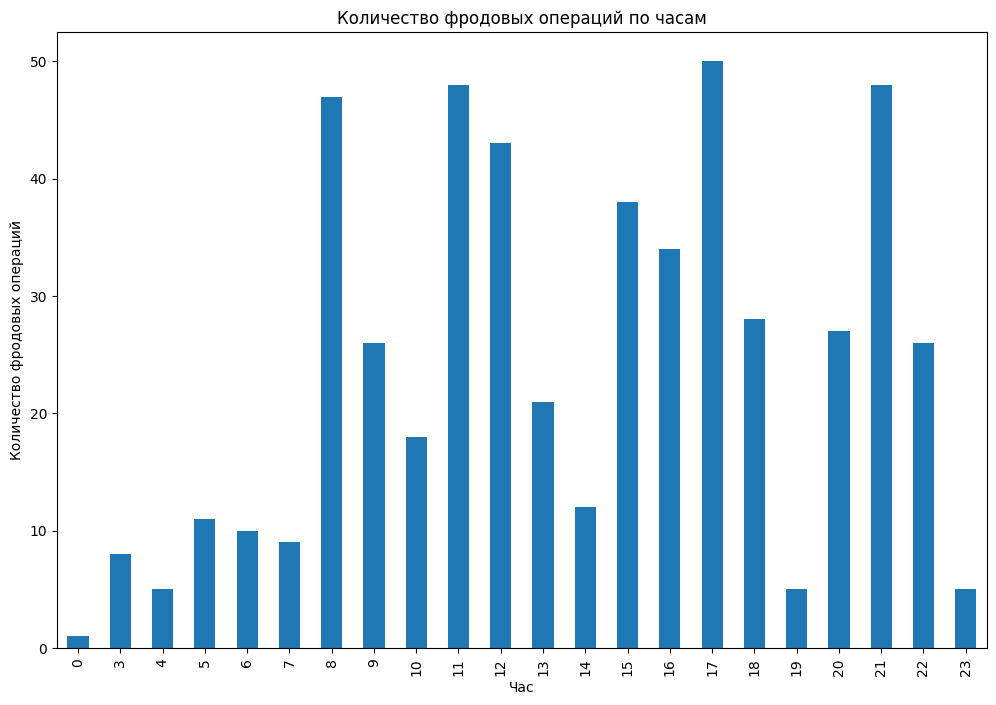

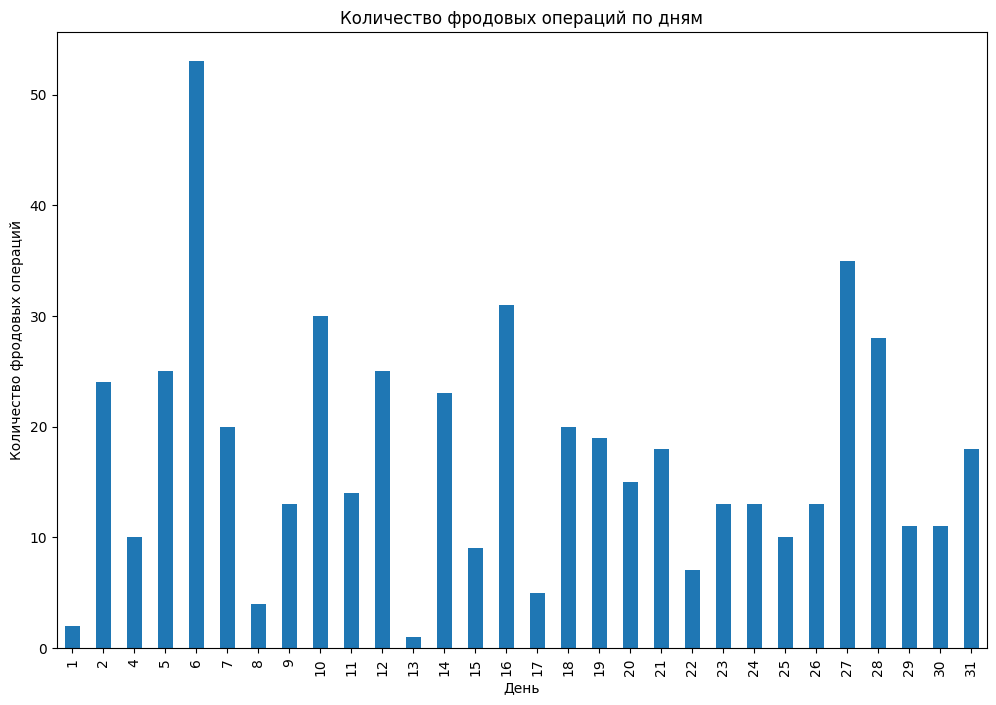

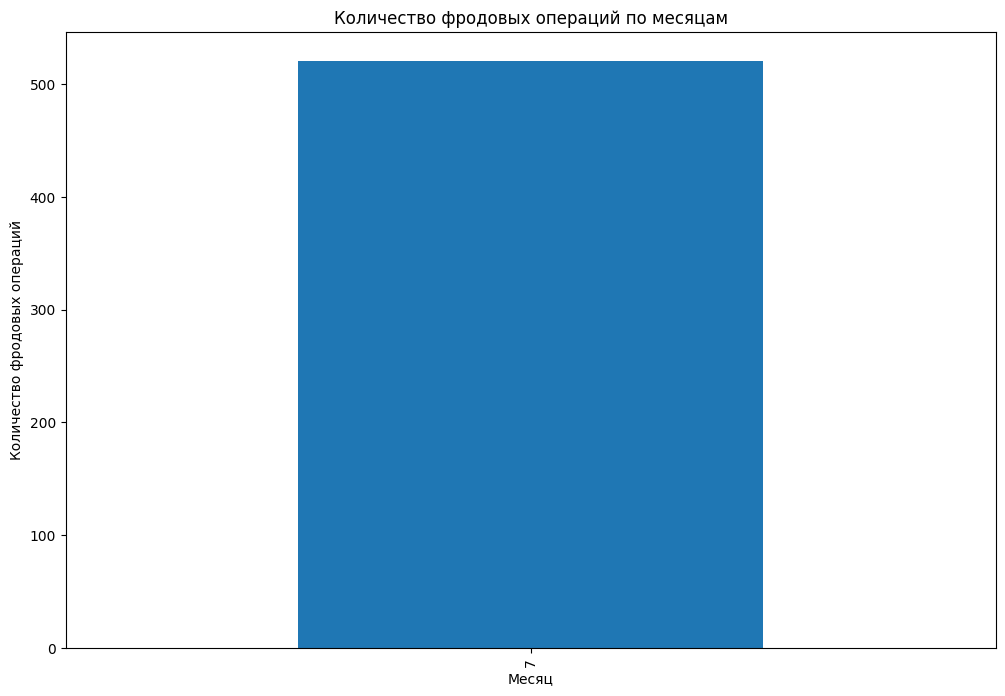

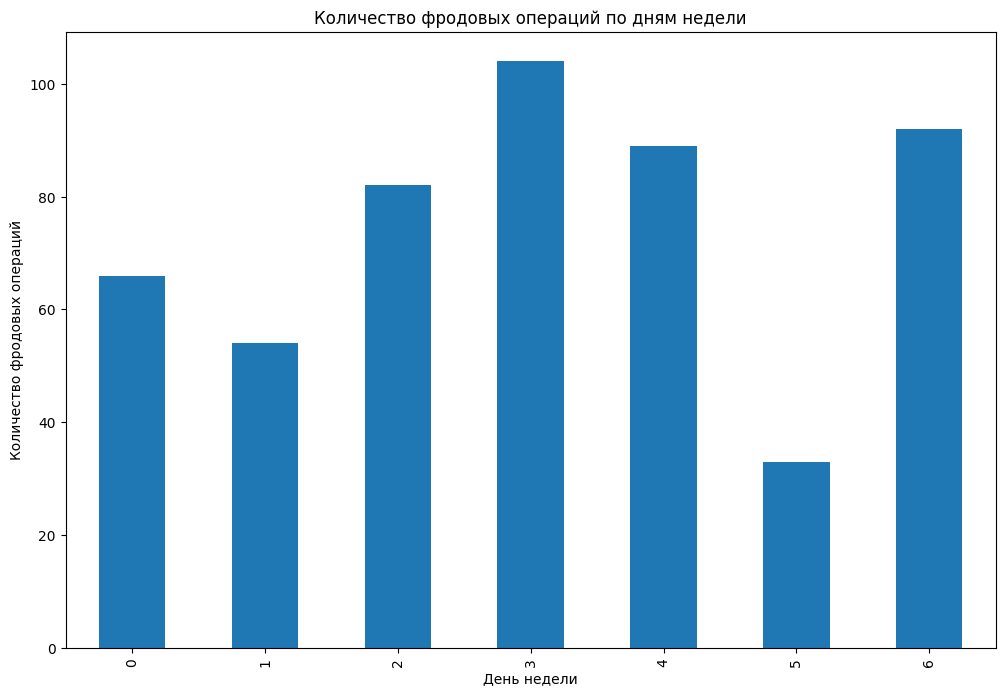

In [92]:
data['TIME'] = pd.to_datetime(data['TIME'])

data['HOUR'] = data['TIME'].dt.hour
data['DAY'] = data['TIME'].dt.day
data['MONTH'] = data['TIME'].dt.month
data['WEEKDAY'] = data['TIME'].dt.dayofweek

fraud_operations = data[data['FRAUD_FLAG'] == 1]

fraud_operations_by_hour = fraud_operations['HOUR'].value_counts().sort_index()
fraud_operations_by_day = fraud_operations['DAY'].value_counts().sort_index()
fraud_operations_by_month = fraud_operations['MONTH'].value_counts().sort_index()
fraud_operations_by_weekday = fraud_operations['WEEKDAY'].value_counts().sort_index()

plt.figure(figsize=(12, 8))
fraud_operations_by_hour.plot(kind='bar')
plt.title('Количество фродовых операций по часам')
plt.xlabel('Час')
plt.ylabel('Количество фродовых операций')
plt.show()

plt.figure(figsize=(12, 8))
fraud_operations_by_day.plot(kind='bar')
plt.title('Количество фродовых операций по дням')
plt.xlabel('День')
plt.ylabel('Количество фродовых операций')
plt.show()

plt.figure(figsize=(12, 8))
fraud_operations_by_month.plot(kind='bar')
plt.title('Количество фродовых операций по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество фродовых операций')
plt.show()

plt.figure(figsize=(12, 8))
fraud_operations_by_weekday.plot(kind='bar')
plt.title('Количество фродовых операций по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество фродовых операций')
plt.show()


Можно отметить, что фродовые операции стали появлятся только в 2023-07-01, до этого их не было

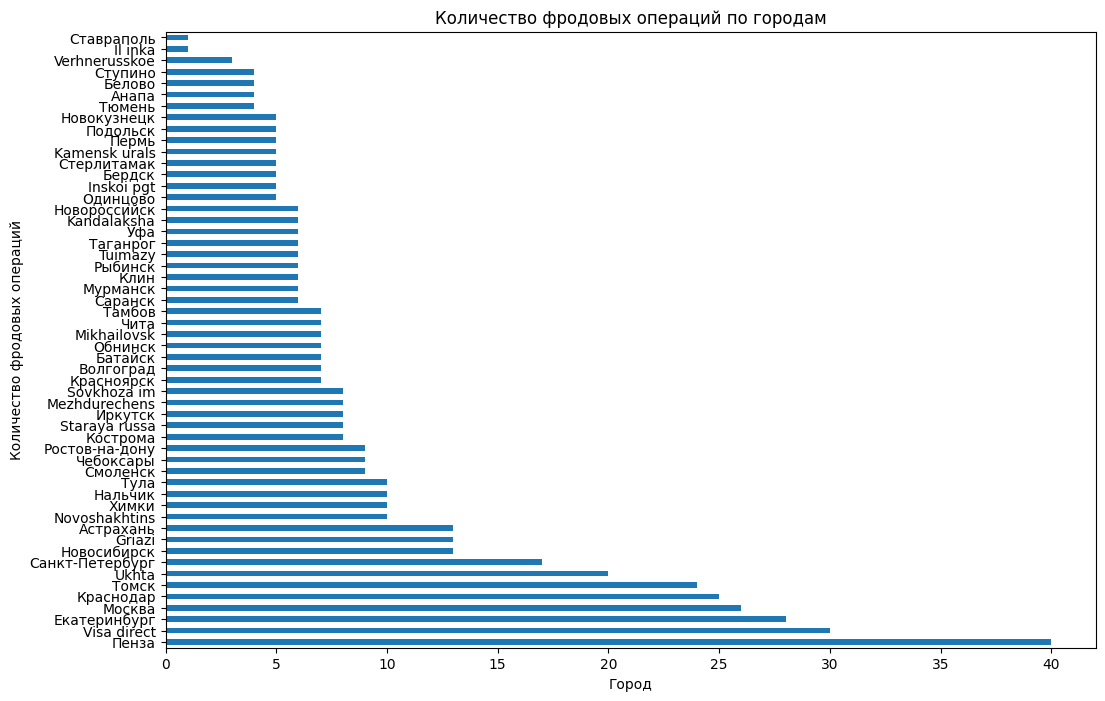

In [93]:
fraud_operations_city = fraud_operations['CITY'].value_counts()

plt.figure(figsize=(12, 8))
fraud_operations_city.plot(kind='barh')
plt.title('Количество фродовых операций по городам')
plt.xlabel('Город')
plt.ylabel('Количество фродовых операций')
plt.show()

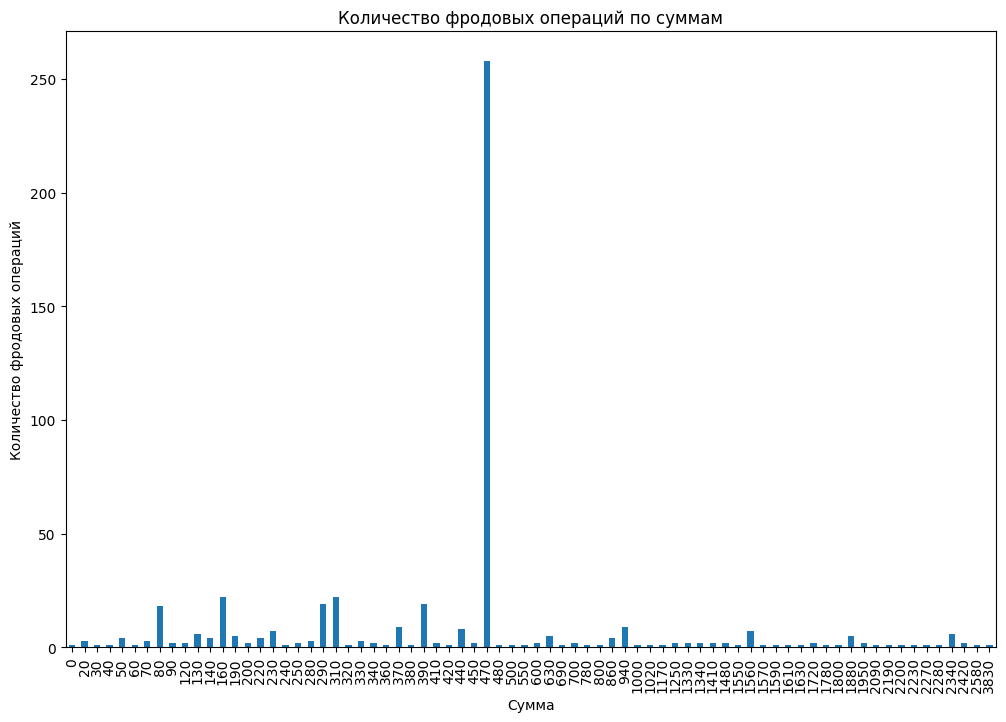

In [98]:
fraud_operations_amount = fraud_operations.groupby('AMOUNT').size()

plt.figure(figsize=(12, 8))
fraud_operations_amount.plot(kind='bar')
plt.title('Количество фродовых операций по суммам')
plt.xlabel('Сумма')
plt.ylabel('Количество фродовых операций')
plt.show()

Как мы видим, очень сильно выделяется сумма 470, проверим ее на всякий случай

Наиболее частая сумма фродовой операции: 470
Количество операций с этой суммой: 258
Типы операций с этой суммой и их количество:
OPERATION_TYPE
Снятие через банкоматы партнеров        232
Пополнение через банкоматы партнеров     26
Name: count, dtype: int64
Города, где часто происходят операции с этой суммой и их количество:
CITY
Екатеринбург    17
Visa direct     15
Москва          14
Нальчик          9
Пенза            9
Name: count, dtype: int64
Банки, где часто происходят операции с этой суммой и их количество:
BANK_ID
3     147
5     100
6       9
20      2
Name: count, dtype: int64


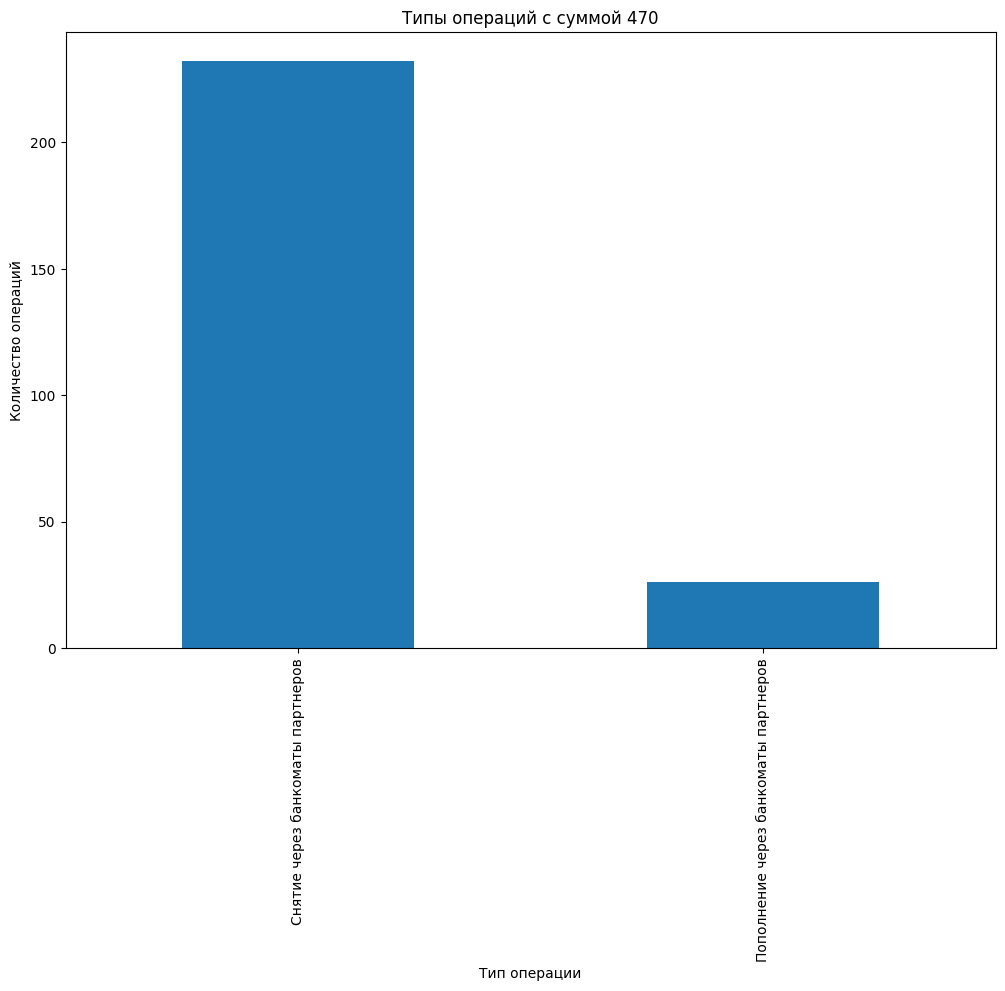

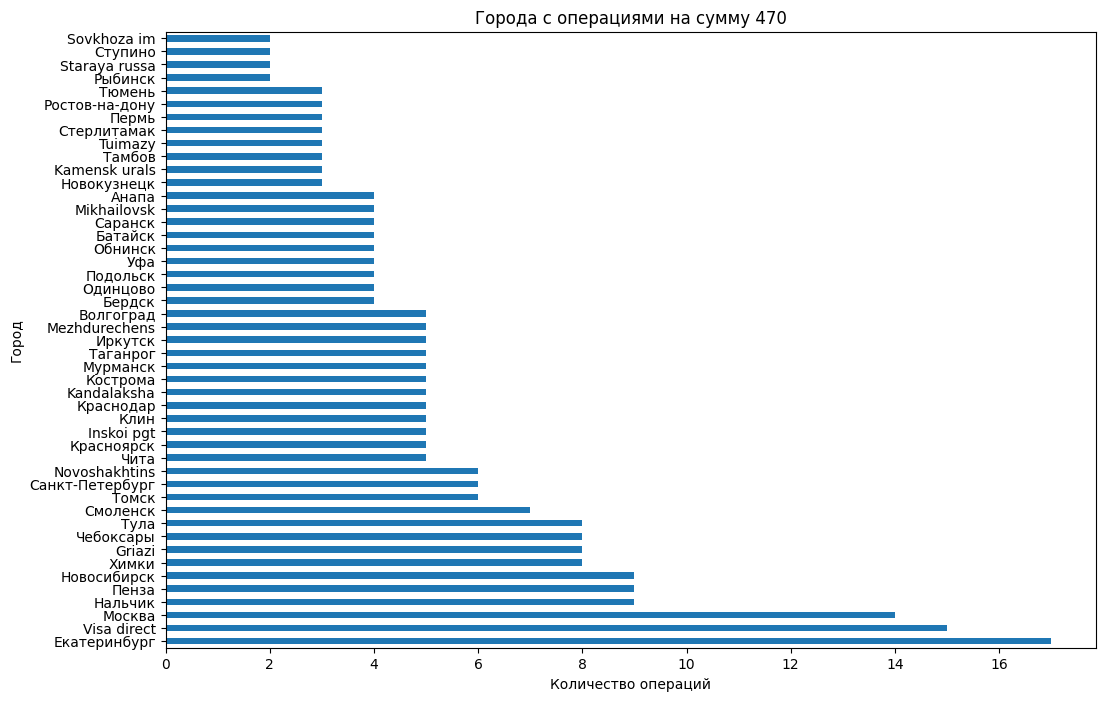

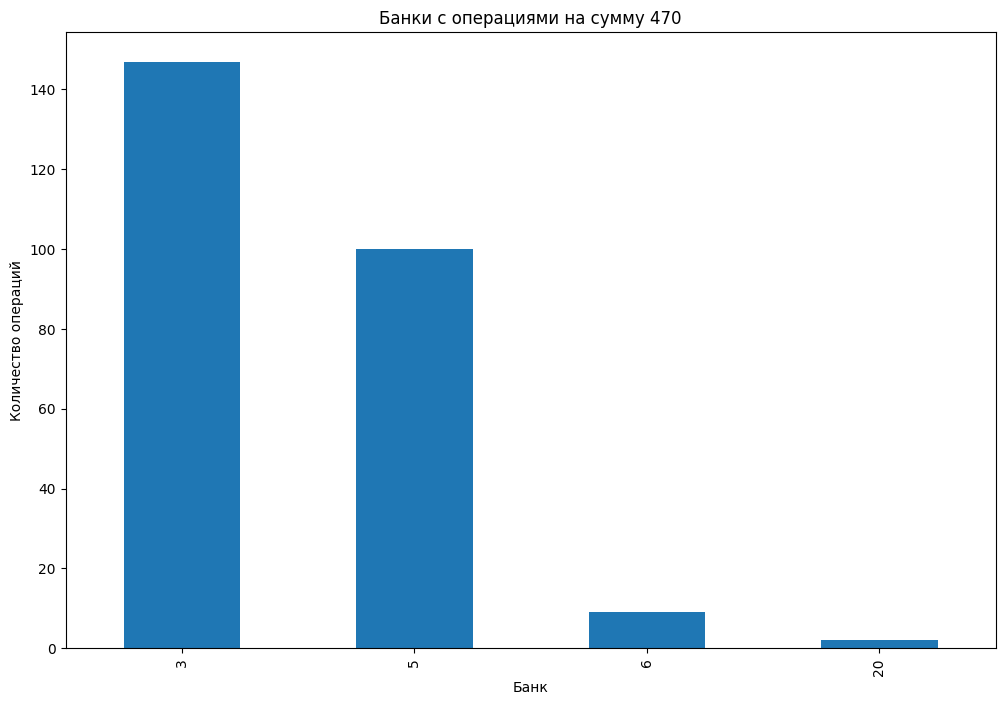

In [99]:
most_common_fraud_amount = 470

common_fraud_operations = fraud_operations[fraud_operations['AMOUNT'] == most_common_fraud_amount]

common_fraud_operations_count = common_fraud_operations.shape[0]

common_fraud_operations_type = common_fraud_operations['OPERATION_TYPE'].value_counts()

common_fraud_operations_city = common_fraud_operations['CITY'].value_counts()

common_fraud_operations_bank = common_fraud_operations['BANK_ID'].value_counts()

print(f"Наиболее частая сумма фродовой операции: {most_common_fraud_amount}")
print(f"Количество операций с этой суммой: {common_fraud_operations_count}")
print("Типы операций с этой суммой и их количество:")
print(common_fraud_operations_type.nlargest())
print("Города, где часто происходят операции с этой суммой и их количество:")
print(common_fraud_operations_city.nlargest())
print("Банки, где часто происходят операции с этой суммой и их количество:")
print(common_fraud_operations_bank.nlargest())

plt.figure(figsize=(12, 8))
common_fraud_operations_type.plot(kind='bar')
plt.title(f'Типы операций с суммой {most_common_fraud_amount}')
plt.xlabel('Тип операции')
plt.ylabel('Количество операций')
plt.show()

plt.figure(figsize=(12, 8))
common_fraud_operations_city.plot(kind='barh')
plt.title(f'Города с операциями на сумму {most_common_fraud_amount}')
plt.xlabel('Количество операций')
plt.ylabel('Город')
plt.show()

plt.figure(figsize=(12, 8))
common_fraud_operations_bank.plot(kind='bar')
plt.title(f'Банки с операциями на сумму {most_common_fraud_amount}')
plt.xlabel('Банк')
plt.ylabel('Количество операций')
plt.show()


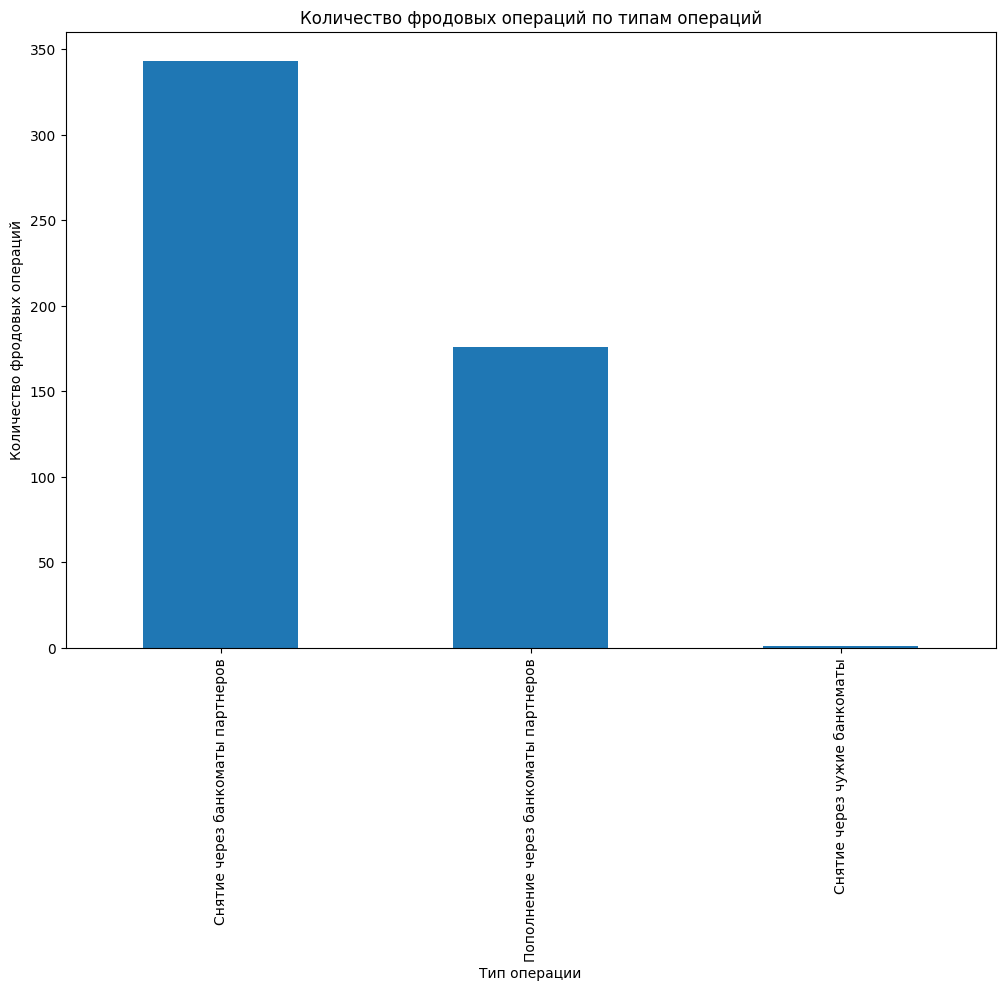

In [83]:
fraud_operations_type = fraud_operations['OPERATION_TYPE'].value_counts()

plt.figure(figsize=(12, 8))
fraud_operations_type.plot(kind='bar')
plt.title('Количество фродовых операций по типам операций')
plt.xlabel('Тип операции')
plt.ylabel('Количество фродовых операций')
plt.show()

Как мы видим, основные фродовые операции это "Снятие через банкоматы партнеров" и "Пополнение через банкоматы партнеров"

In [84]:
bank_3_partner = data[data['BANK_ID'] == 3]['OPERATION_TYPE'].str.contains('партнеров').any()
bank_5_partner = data[data['BANK_ID'] == 5]['OPERATION_TYPE'].str.contains('партнеров').any()

print(f"Банк с ID 3 является банком партнером: {bank_3_partner}")
print(f"Банк с ID 5 является банком партнером: {bank_5_partner}")

Банк с ID 3 является банком партнером: True
Банк с ID 5 является банком партнером: True


In [85]:
similar_clients = data[data['FRAUD_FLAG'] == 0].copy()

similar_clients.loc[:, 'YEAR_MONTH'] = pd.to_datetime(similar_clients['TIME']).dt.to_period('M')
total_operations_by_month = data.groupby(['YEAR_MONTH', 'OPERATION_TYPE']).size()
similar_operations_by_month = similar_clients.groupby(['YEAR_MONTH', 'OPERATION_TYPE']).size()

operation_share = (similar_operations_by_month / total_operations_by_month).fillna(0) * 100

data_encoded = data.copy()

categorical_columns = ['CITY', 'OPERATION_TYPE']
for column in categorical_columns:
    data_encoded[column] = data_encoded[column].astype('category').cat.codes

columns_to_exclude = ['CLIENT_ID', 'TIME', 'YEAR_MONTH']
data_for_corr = data_encoded.drop(columns=columns_to_exclude)

correlation_matrix = data_for_corr.corr()

In [86]:
print("Доля операций аналогичных клиентов с FRAUD_FLAG = 0:")
operation_share

Доля операций аналогичных клиентов с FRAUD_FLAG = 0:


YEAR_MONTH  OPERATION_TYPE                      
2023-05     Пополнение через банкоматы партнеров    100.000000
            Пополнение через наши банкоматы         100.000000
            Снятие через банкоматы партнеров        100.000000
            Снятие через наши банкоматы             100.000000
            Снятие через чужие банкоматы            100.000000
2023-06     Пополнение через банкоматы партнеров    100.000000
            Пополнение через наши банкоматы         100.000000
            Снятие через банкоматы партнеров        100.000000
            Снятие через наши банкоматы             100.000000
            Снятие через чужие банкоматы            100.000000
2023-07     Пополнение через банкоматы партнеров     99.577877
            Пополнение через наши банкоматы         100.000000
            Снятие через банкоматы партнеров         98.931797
            Снятие через наши банкоматы             100.000000
            Снятие через чужие банкоматы             99.998104
dtype:

<Figure size 1200x800 with 0 Axes>

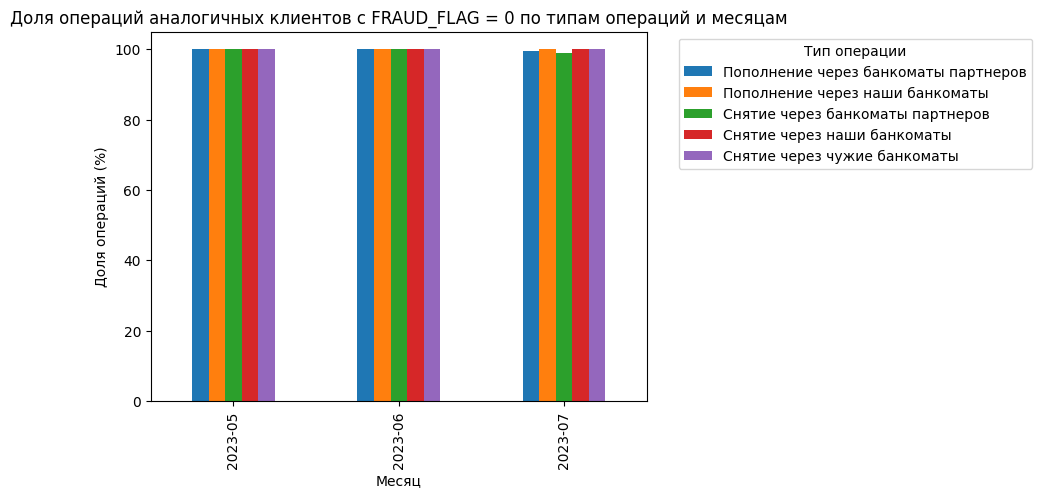

In [87]:
plt.figure(figsize=(12, 8))
operation_share.unstack().plot(kind='bar')
plt.title('Доля операций аналогичных клиентов с FRAUD_FLAG = 0 по типам операций и месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доля операций (%)')
plt.legend(title='Тип операции', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

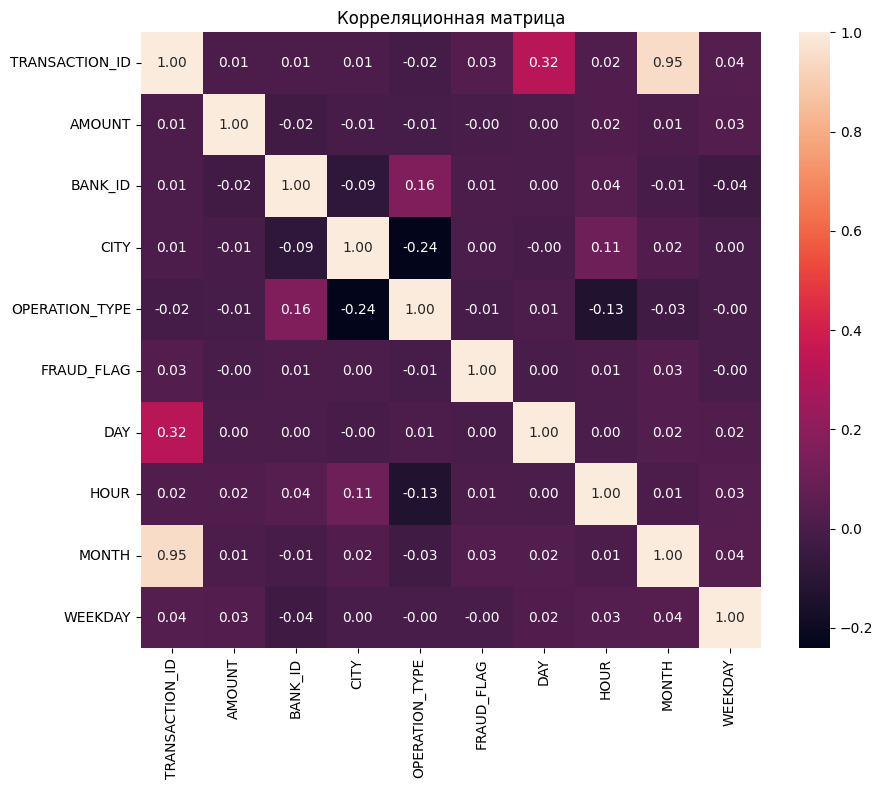

In [88]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

На основе представленных данных можно сделать следующие выводы:

- **Банки с фродовыми операциями:** Все выявленные фродовые операции произошли в Банках №3 и №5.

- **Временной аспект:** Фродовые операции появились в июле 2023 года.

- **Типы операций:** Основные типы фродовых операций включают "Пополнение через банкоматы партнеров" и "Снятие через банкоматы партнеров".

- **Частота сумм:** Наиболее часто встречающаяся сумма фродовой операции составляет 470 рублей.

# Общий вывод

В результате анализа данных о банковских операциях были выявлены следующие ключевые выводы:

- Большинство обнаруженных мошеннических операций происходили в Банках №3 и №5, а также связаны с типами операций "Пополнение через банкоматы партнеров" и "Снятие через банкоматы партнеров". Нужно ввести дополнительные меры безапосности с этими банками

- Также в данных есть аномальное поведение пользователей, которые совершали фродовые операции, так как в течение двух месяцев они совершали обычные операции, но потом резко с наступлением июля начали совершать только фродовые операции. Исходя из этого можно предположить, что они были взломаны или были введены в заблуждение мошенниками